# Final Project

Importing python libraries and packages needed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Mount personal Google Drive directory onto Google Colab environment.

This is so that I can read the dataset in the colab environment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Path to dataset
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Final Project/animals-10/raw-img"

## Load Training and Validation datasets

Using Keras APIs.

Batch size is defined as 128

Images are resized to 150x150 for performance.

Training 80%, Validation 20%

In [ ]:
num_classes = 10
batch_size = 128
img_height = 150
img_width = 150

train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 26985 files belonging to 10 classes.
Using 21588 files for training.
Found 26985 files belonging to 10 classes.
Using 5397 files for validation.


## Visualise labels distribution

We visualise only the validation set but training set distribution is proportional.

We gather the labels for all the images in the validation set. Then we count the ocurrances of each one and draw a graph to visualise them.

total number of labels:  5397
['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


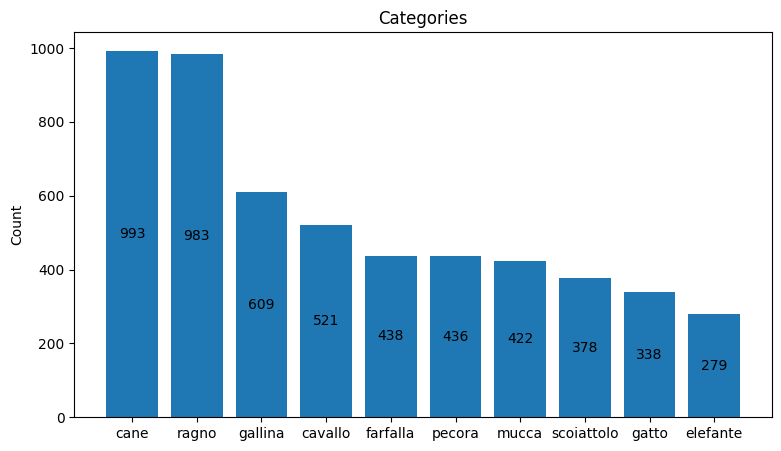

In [ ]:
#gather all the labels in a single list
labels_list = []
for batch in val_ds.as_numpy_iterator():
  (images, labels) = batch
  labels_list.extend(labels)

print("total number of labels: ", len(labels_list))

#map labels from integer value to animal name strings
class_names = train_ds.class_names
print(class_names)
val_labels_df = pd.DataFrame(labels_list, columns =['Labels'])
val_labels_df['Labels'] = val_labels_df['Labels'].map(lambda label_int: class_names[label_int])

#calculate value counts (distribution) and display
val_labels_distribution = val_labels_df['Labels'].value_counts()

val_labels_distribution.index.to_numpy()
val_labels_distribution.array.to_numpy()

fig, ax = plt.subplots(figsize=(9, 5))

container = ax.bar(val_labels_distribution.index.to_numpy(), val_labels_distribution.array.to_numpy())
ax.bar_label(container, label_type='center')

ax.set_ylabel('Count')
ax.set_title('Categories')

plt.show()

## Visualise a few images

We visualise a few images from the training set to validate that all looks good at this point and the labels match the animals in the pictures.

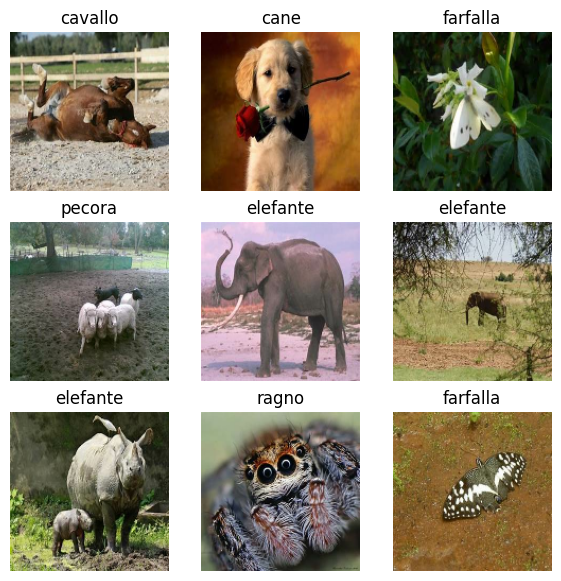

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


## Configure and preprocess the datasets

### Prefetching for performance

Train and Validation datasets are configured to handle prefetching of images asynchronously to speed up training by loading images before they are needed.

See: https://www.tensorflow.org/guide/data_performance

In [ ]:
#Configure datasets for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Validate tensor shapes

Batch should have following shapes:
- Images (128, 150, 150, 3)
  *   128 is the batch size
  *   150, 150 is the image size
  *   3 is the number of colour channels (RGB)
- Labels (128, ) 1 label per image in the batch (128)


We also visualise that the labels are integers values ranging from 0-9, they need to be converted to categorical values next



In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  print(labels_batch)
  break


(128, 150, 150, 3)
(128,)
tf.Tensor(
[8 8 4 2 0 6 0 8 1 2 7 8 8 9 5 1 4 5 5 8 1 4 0 3 0 5 9 4 8 7 4 8 4 0 1 0 0
 5 1 6 1 0 1 7 6 9 3 8 0 5 7 4 6 0 5 2 0 1 0 1 8 5 7 7 7 7 1 4 0 1 8 8 8 0
 3 0 8 5 0 0 0 0 0 5 0 8 4 8 5 7 4 5 9 4 8 0 9 3 0 1 8 0 7 5 7 7 0 3 9 5 1
 1 3 8 8 3 0 5 1 4 3 0 9 1 8 9 1 3], shape=(128,), dtype=int32)


### Converting Labels to Categorical one-hot encodings

We map both training and validation datasets using a function which turns labels into categorical encodings. We then visualise the labels in a batch to validate that they are now indeed hot-encoded vectors made ups of zeros and ones.

In [ ]:
#Transform labels to one-hot encoded vectors
def labelToCategorical(img, label):
  label = tf.one_hot(tf.cast(label, tf.uint8), num_classes)
  return img, label

processed_train_ds = train_ds.map(labelToCategorical)
processed_val_ds = val_ds.map(labelToCategorical)

for image_batch, labels_batch in processed_train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  print(labels_batch)
  break


(128, 150, 150, 3)
(128, 10)
tf.Tensor(
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]], shape=(128, 10), dtype=float32)


## Define Model Evaludation and Visualisation Functions

These functions will be used later for each of our models in order to visualise their performance.

They are created in advanced so as to keep things organised and easy to reference later in case we need to update any of these functions.

### Functions to plot validation Loss and Accuracy

The following functions plot the validation loss and accuracy of a given model's history. This will be used to analyse the models' performances.

In [ ]:
#The following function is an adaptation of the code shown in the lectures of
#module CM3015.
def plot_epochs(x, graphs,
                title, x_label, y_label):

  plt.clf()
  for g in graphs:
    plt.plot(x, g['ys'], g['style'], label = g['label'])

  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()

def plot_val_loss_and_accuracy(history):
  history_dict = history.history

  graphs = [{"ys": history_dict['loss'],
             "style": 'bo',
             "label": 'Training'},
            {"ys": history_dict['val_loss'],
             "style": 'b',
             "label": 'Validation'}]
  plot_epochs(range(1, len(history_dict['loss']) + 1),
            graphs, 'Training and validation loss',
            'Epochs', 'Loss')

  print("Ideal epoch for validation loss: ", np.argmin(history_dict['val_loss']) + 1, 'epochs')
  print("Validation loss: ", history_dict['val_loss'][np.argmin(history_dict['val_loss'])])

  graphs = [{"ys": history_dict['accuracy'],
             "style": 'ro',
             "label": 'Training'},
            {"ys": history_dict['val_accuracy'],
             "style": 'r',
             "label": 'Validation'}]
  plot_epochs(range(1, len(history_dict['accuracy']) + 1),
              graphs, 'Training and validation accuracy',
              'Epochs', 'Accuracy')

  print("Ideal epoch for validation accuracy: ", np.argmax(history_dict['val_accuracy']) + 1, 'epochs')
  print("Validation accuracy: ", history_dict['val_accuracy'][np.argmax(history_dict['val_accuracy'])])

### Functions to display Confusion Matrix and Classification Report

The following functions are used to display a confusion matrix based on a model's predictions, and to display a classification report with all the key metrics to look at regarding the model's performances.



In [ ]:
def displayConfusionMatrix(predictions, dataset):
  #Get true labels from dataset
  labels =  np.array([])
  for x, y in dataset:
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

  fig, ax = plt.subplots(figsize=(8,8))
  ConfusionMatrixDisplay.from_predictions(
      labels, np.argmax(predictions, axis=1),
      display_labels=class_names, cmap=plt.cm.Blues,
      ax=ax, xticks_rotation="vertical", normalize='pred')

def displayClassificationReport(predictions, dataset):
  #Get true labels from dataset
  labels =  np.array([])
  for x, y in dataset:
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

  cr = metrics.classification_report(
    labels,
    np.argmax(predictions, axis=1),
    target_names=class_names
  )

  print(cr)

## Multilayer Perceptron / Densely Connected Neural Network (DNN)

Below is the code to create and run the DNN network. It is meant to be used as a baseline to be compared with the CNN network we will create afterwards.

In [ ]:



dnn_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(150,150,3)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

dnn_model.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])



In [ ]:
dnn_history = dnn_model.fit(
  processed_train_ds,
  validation_data=processed_val_ds,
  epochs=20
)


Epoch 1/20
169/169 [==============================] - 126s 738ms/step - loss: 5.2324 - accuracy: 0.1995 - val_loss: 2.0776 - val_accuracy: 0.2527
Epoch 2/20
169/169 [==============================] - 125s 737ms/step - loss: 2.0305 - accuracy: 0.2626 - val_loss: 1.9951 - val_accuracy: 0.3026
Epoch 3/20
169/169 [==============================] - 125s 737ms/step - loss: 1.9454 - accuracy: 0.3021 - val_loss: 1.9312 - val_accuracy: 0.3126
Epoch 4/20
169/169 [==============================] - 124s 736ms/step - loss: 1.9088 - accuracy: 0.3144 - val_loss: 1.9047 - val_accuracy: 0.3256
Epoch 5/20
169/169 [==============================] - 124s 735ms/step - loss: 1.8777 - accuracy: 0.3275 - val_loss: 1.8640 - val_accuracy: 0.3456
Epoch 6/20
169/169 [==============================] - 124s 736ms/step - loss: 1.8563 - accuracy: 0.3350 - val_loss: 1.8843 - val_accuracy: 0.3337
Epoch 7/20
169/169 [==============================] - 124s 736ms/step - loss: 1.8203 - accuracy: 0.3523 - val_loss: 1.8793 -

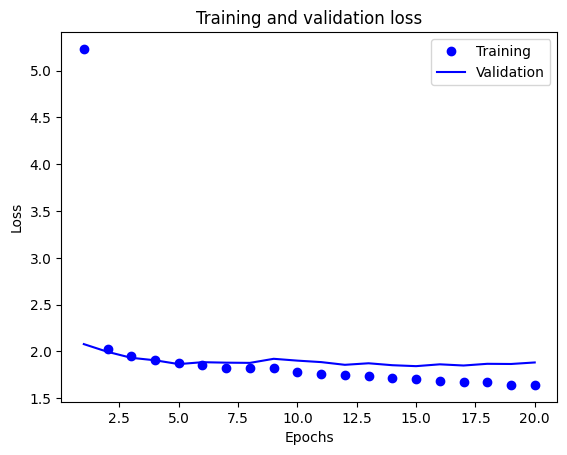

Ideal epoch for validation loss:  15 epochs
Validation loss:  1.841981053352356


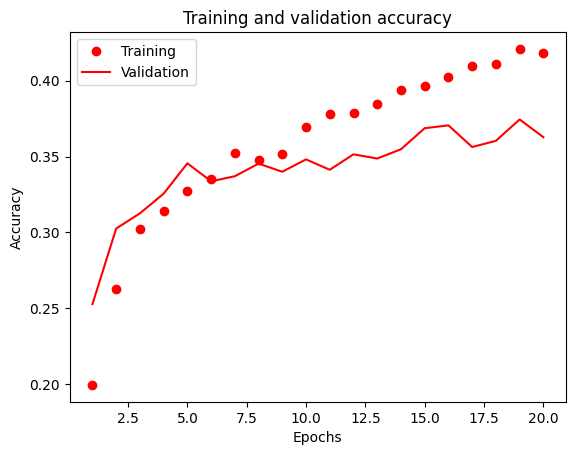

Ideal epoch for validation accuracy:  19 epochs
Validation accuracy:  0.37446728348731995


In [ ]:
plot_val_loss_and_accuracy(dnn_history)

43/43 [==============================] - 3s 76ms/step


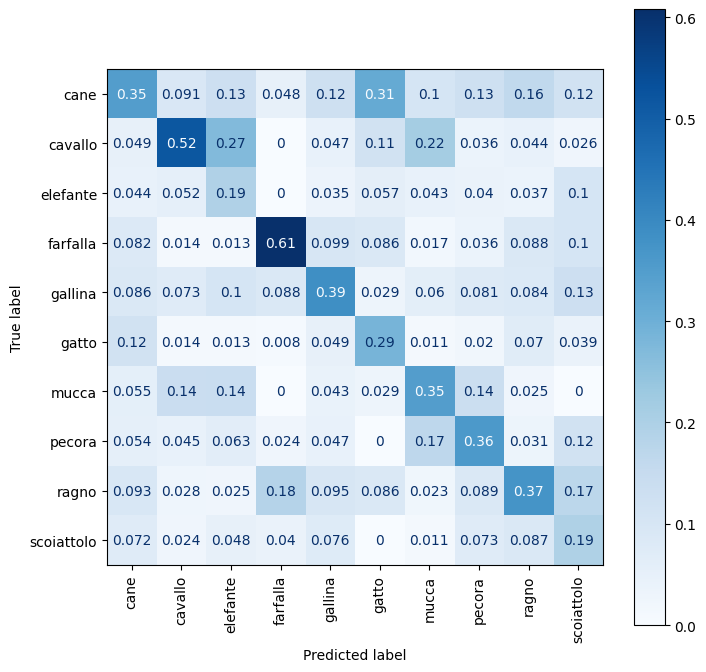

In [ ]:
dnn_predictions = dnn_model.predict(processed_val_ds)
displayConfusionMatrix(dnn_predictions, processed_val_ds)

In [ ]:
displayClassificationReport(dnn_predictions, processed_val_ds)

              precision    recall  f1-score   support

        cane       0.35      0.42      0.38       993
     cavallo       0.52      0.28      0.37       521
    elefante       0.19      0.28      0.23       279
    farfalla       0.61      0.17      0.27       438
     gallina       0.39      0.33      0.35       609
       gatto       0.29      0.03      0.05       338
       mucca       0.35      0.29      0.31       422
      pecora       0.36      0.41      0.38       436
       ragno       0.37      0.72      0.49       983
  scoiattolo       0.19      0.04      0.07       378

    accuracy                           0.36      5397
   macro avg       0.36      0.30      0.29      5397
weighted avg       0.37      0.36      0.33      5397



## Convolutional Neural Networks (CNN)

First attempt at a CNN, aiming to overfit first and then optimise.

In [ ]:
cnn_model = tf.keras.models.Sequential()

cnn_model.add(tf.keras.layers.Rescaling(1./255, input_shape=(150,150,3)))

cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(2))


cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(2))


cnn_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(2))


cnn_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(2))

cnn_model.add(tf.keras.layers.Flatten())

cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))


cnn_model.add(tf.keras.layers.Dense(10, activation='softmax'))

cnn_model.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [ ]:
cnn_history = cnn_model.fit(
  processed_train_ds,
  validation_data=processed_val_ds,
  epochs=20
)

Epoch 1/20
169/169 [==============================] - 147s 864ms/step - loss: 1.8426 - accuracy: 0.3476 - val_loss: 1.4713 - val_accuracy: 0.5031
Epoch 2/20
169/169 [==============================] - 147s 871ms/step - loss: 1.3338 - accuracy: 0.5468 - val_loss: 1.2384 - val_accuracy: 0.5800
Epoch 3/20
169/169 [==============================] - 146s 866ms/step - loss: 1.0834 - accuracy: 0.6384 - val_loss: 1.0666 - val_accuracy: 0.6446
Epoch 4/20
169/169 [==============================] - 146s 867ms/step - loss: 0.9204 - accuracy: 0.6911 - val_loss: 1.0306 - val_accuracy: 0.6591
Epoch 5/20
169/169 [==============================] - 146s 867ms/step - loss: 0.8119 - accuracy: 0.7236 - val_loss: 1.0521 - val_accuracy: 0.6622
Epoch 6/20
169/169 [==============================] - 147s 871ms/step - loss: 0.7178 - accuracy: 0.7573 - val_loss: 1.0829 - val_accuracy: 0.6698
Epoch 7/20
169/169 [==============================] - 148s 879ms/step - loss: 0.6122 - accuracy: 0.7932 - val_loss: 1.0818 -

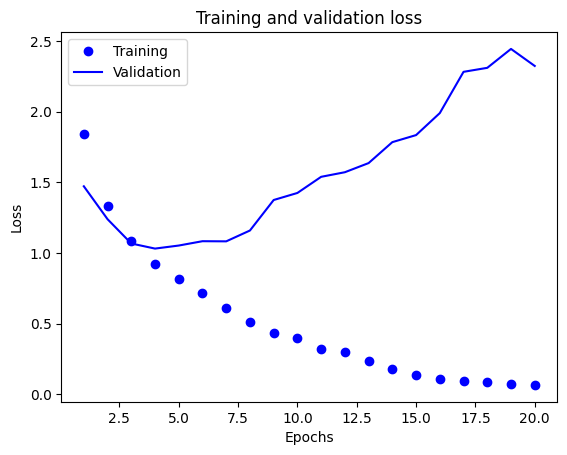

Ideal epoch for validation loss:  4 epochs
Validation loss:  1.0306075811386108


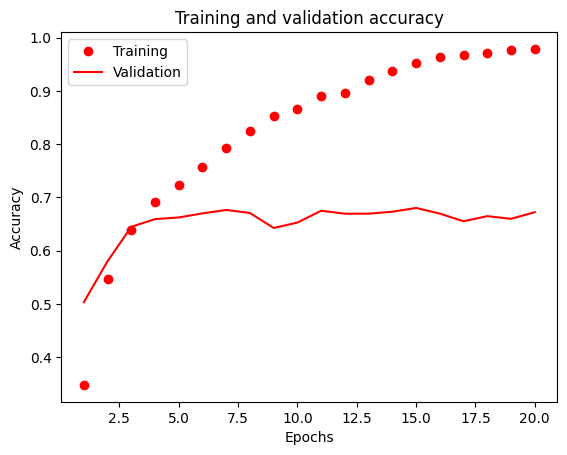

Ideal epoch for validation accuracy:  15 epochs
Validation accuracy:  0.6800073981285095


In [ ]:
plot_val_loss_and_accuracy(cnn_history)

43/43 [==============================] - 7s 169ms/step


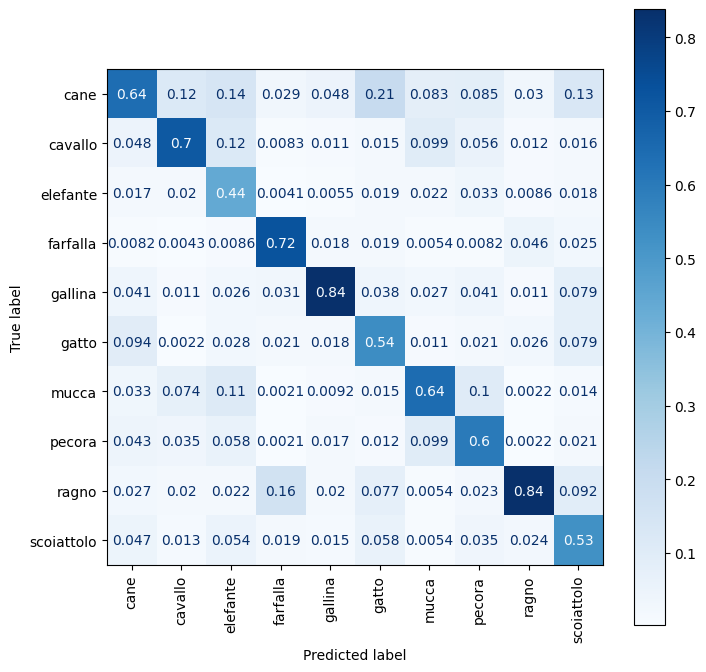

In [ ]:
cnn_predictions = cnn_model.predict(processed_val_ds)
displayConfusionMatrix(cnn_predictions, processed_val_ds)

In [ ]:
displayClassificationReport(cnn_predictions, processed_val_ds)

              precision    recall  f1-score   support

        cane       0.64      0.63      0.63       993
     cavallo       0.70      0.62      0.66       521
    elefante       0.44      0.73      0.55       279
    farfalla       0.72      0.80      0.76       438
     gallina       0.84      0.74      0.79       609
       gatto       0.54      0.41      0.47       338
       mucca       0.64      0.57      0.60       422
      pecora       0.60      0.67      0.63       436
       ragno       0.84      0.79      0.81       983
  scoiattolo       0.53      0.60      0.56       378

    accuracy                           0.67      5397
   macro avg       0.65      0.66      0.65      5397
weighted avg       0.68      0.67      0.67      5397



### CNN 1 Evaluation
Much better results than the DNN network, but heavy overfitting happening.
We need to try regularisation techniques.

## CNN Network 2: Adding dropout regularisation to address overfitting.

Dropout layers have been added throughout the network.

In [ ]:
cnn_dropout_model = tf.keras.models.Sequential()

cnn_dropout_model.add(tf.keras.layers.Rescaling(1./255, input_shape=(150,150,3)))

cnn_dropout_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn_dropout_model.add(tf.keras.layers.MaxPooling2D(2))
cnn_dropout_model.add(tf.keras.layers.Dropout(0.4))


cnn_dropout_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_dropout_model.add(tf.keras.layers.MaxPooling2D(2))
cnn_dropout_model.add(tf.keras.layers.Dropout(0.4))


cnn_dropout_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_dropout_model.add(tf.keras.layers.MaxPooling2D(2))
cnn_dropout_model.add(tf.keras.layers.Dropout(0.4))


cnn_dropout_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_dropout_model.add(tf.keras.layers.MaxPooling2D(2))
cnn_dropout_model.add(tf.keras.layers.Dropout(0.4))


cnn_dropout_model.add(tf.keras.layers.Flatten())
cnn_dropout_model.add(tf.keras.layers.Dropout(0.2))
cnn_dropout_model.add(tf.keras.layers.Dense(256, activation='relu'))
cnn_dropout_model.add(tf.keras.layers.Dense(10, activation='softmax'))

cnn_dropout_model.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [ ]:
cnn_dropout_history = cnn_dropout_model.fit(
  processed_train_ds,
  validation_data=processed_val_ds,
  epochs=20
)

Epoch 1/20
169/169 [==============================] - 197s 1s/step - loss: 2.1402 - accuracy: 0.2272 - val_loss: 2.0192 - val_accuracy: 0.3459
Epoch 2/20
169/169 [==============================] - 146s 863ms/step - loss: 1.7747 - accuracy: 0.3808 - val_loss: 1.7241 - val_accuracy: 0.4117
Epoch 3/20
169/169 [==============================] - 144s 850ms/step - loss: 1.5620 - accuracy: 0.4583 - val_loss: 1.5312 - val_accuracy: 0.5034
Epoch 4/20
169/169 [==============================] - 143s 847ms/step - loss: 1.3583 - accuracy: 0.5375 - val_loss: 1.6595 - val_accuracy: 0.4515
Epoch 5/20
169/169 [==============================] - 144s 855ms/step - loss: 1.2362 - accuracy: 0.5767 - val_loss: 1.5326 - val_accuracy: 0.4871
Epoch 6/20
169/169 [==============================] - 143s 845ms/step - loss: 1.1418 - accuracy: 0.6116 - val_loss: 1.3966 - val_accuracy: 0.5360
Epoch 7/20
169/169 [==============================] - 145s 857ms/step - loss: 1.0713 - accuracy: 0.6322 - val_loss: 1.4328 - va

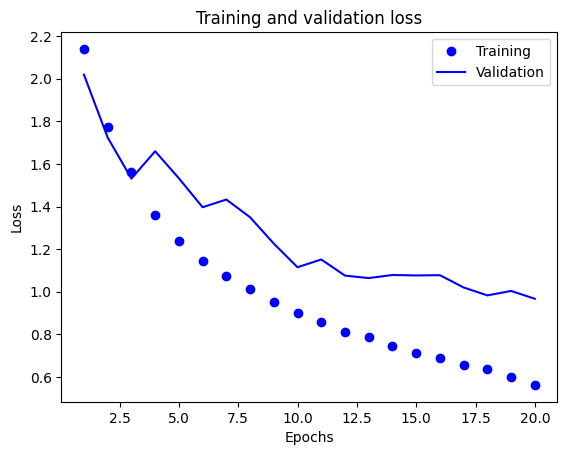

Ideal epoch for validation loss:  20 epochs
Validation loss:  0.9666166305541992


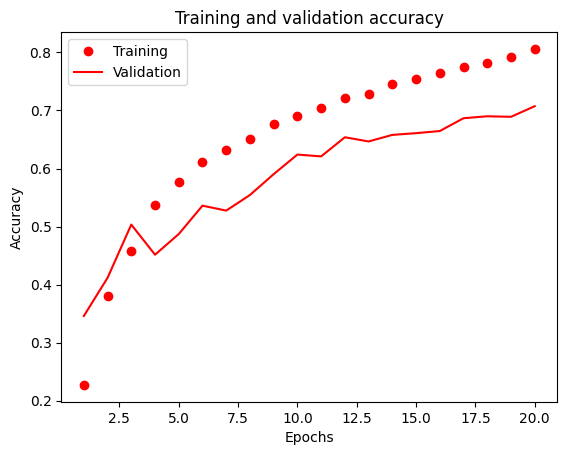

Ideal epoch for validation accuracy:  20 epochs
Validation accuracy:  0.7074300646781921


In [ ]:
plot_val_loss_and_accuracy(cnn_dropout_history)

43/43 [==============================] - 7s 151ms/step


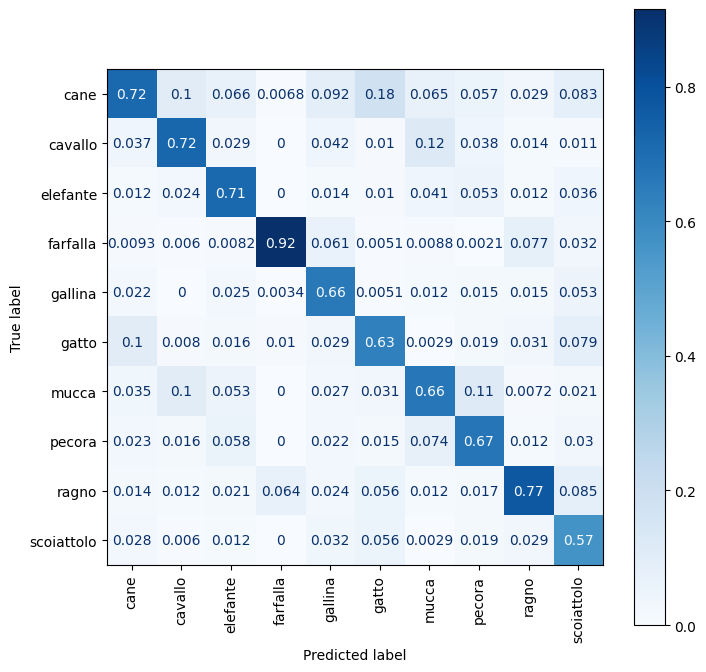

In [ ]:
cnn_dropout_predictions = cnn_dropout_model.predict(processed_val_ds)
displayConfusionMatrix(cnn_dropout_predictions, processed_val_ds)

In [ ]:
displayClassificationReport(cnn_dropout_predictions, processed_val_ds)

              precision    recall  f1-score   support

        cane       0.72      0.70      0.71       993
     cavallo       0.72      0.70      0.71       521
    elefante       0.71      0.62      0.66       279
    farfalla       0.92      0.62      0.74       438
     gallina       0.66      0.87      0.75       609
       gatto       0.63      0.36      0.46       338
       mucca       0.66      0.53      0.59       422
      pecora       0.67      0.73      0.70       436
       ragno       0.77      0.87      0.82       983
  scoiattolo       0.57      0.70      0.63       378

    accuracy                           0.71      5397
   macro avg       0.70      0.67      0.68      5397
weighted avg       0.71      0.71      0.70      5397



### CNN 2 Evaluation

Dropout really helped reduce overfitting. Better F1 score achieved compared with CNN network without dropout layers.

## CNN Network 3: Using Data Augmentation

I will try anther technique that helps overfitting and will compare it to dropout. The technique is data augmentation.

### Set up data augmentation layers and visualising it

Below I setup a data augmentation set of layers which will be used to modify images in the dataset.

I also define a function that, given an image, it will create a few augmentations and display them in order for me to verify that everything is working as expected.

In [ ]:
#Setup data augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomTranslation(0.2,0.2,'nearest'),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomBrightness(0.2),
])


In [ ]:
def visualize_augmentations(original, augmentation_layer):

  #Show original image
  fig = plt.figure(figsize=(2, 2))
  plt.title('Original image')
  plt.imshow(original.numpy().astype("uint8"))

  #create 9 random augmentations and display them
  plt.figure(figsize=(6, 6))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented = data_augmentation(original)
    plt.imshow(augmented.numpy().astype("uint8"))
    plt.title("augmentation " + str(i+1))
    plt.axis("off")

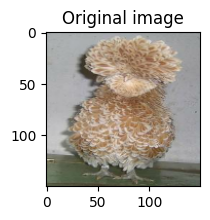

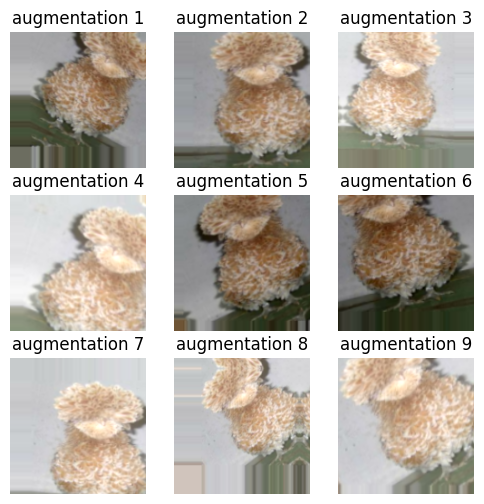

In [ ]:
#Fetch random image and generate augmentations for testing
random_image = None
random_label= None

for image, label in train_ds.unbatch().take(1):
  random_image = image
  random_label = label

visualize_augmentations(random_image, data_augmentation)

In [ ]:
cnn_dropout_augmented_model = tf.keras.models.Sequential()

#data augmentation and rescaling
cnn_dropout_augmented_model.add(data_augmentation)
cnn_dropout_augmented_model.add(tf.keras.layers.Rescaling(1./255))

cnn_dropout_augmented_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn_dropout_augmented_model.add(tf.keras.layers.MaxPooling2D(2))


cnn_dropout_augmented_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_dropout_augmented_model.add(tf.keras.layers.MaxPooling2D(2))


cnn_dropout_augmented_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_dropout_augmented_model.add(tf.keras.layers.MaxPooling2D(2))


cnn_dropout_augmented_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_dropout_augmented_model.add(tf.keras.layers.MaxPooling2D(2))


cnn_dropout_augmented_model.add(tf.keras.layers.Flatten())
cnn_dropout_augmented_model.add(tf.keras.layers.Dense(256, activation='relu'))
cnn_dropout_augmented_model.add(tf.keras.layers.Dense(10, activation='softmax'))

cnn_dropout_augmented_model.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [ ]:
cnn_dropout_augmented_history = cnn_dropout_augmented_model.fit(
  processed_train_ds,
  validation_data=processed_val_ds,
  epochs=20
)

Epoch 1/20
169/169 [==============================] - 135s 790ms/step - loss: 2.1166 - accuracy: 0.2441 - val_loss: 2.0918 - val_accuracy: 0.2874
Epoch 2/20
169/169 [==============================] - 134s 794ms/step - loss: 1.8067 - accuracy: 0.3719 - val_loss: 1.7076 - val_accuracy: 0.4065
Epoch 3/20
169/169 [==============================] - 134s 792ms/step - loss: 1.6210 - accuracy: 0.4472 - val_loss: 1.6808 - val_accuracy: 0.4186
Epoch 4/20
169/169 [==============================] - 133s 788ms/step - loss: 1.4896 - accuracy: 0.4930 - val_loss: 1.5493 - val_accuracy: 0.4691
Epoch 5/20
169/169 [==============================] - 133s 788ms/step - loss: 1.4107 - accuracy: 0.5213 - val_loss: 1.4547 - val_accuracy: 0.4801
Epoch 6/20
169/169 [==============================] - 134s 791ms/step - loss: 1.3186 - accuracy: 0.5478 - val_loss: 1.5943 - val_accuracy: 0.4349
Epoch 7/20
169/169 [==============================] - 134s 792ms/step - loss: 1.2668 - accuracy: 0.5666 - val_loss: 1.3901 -

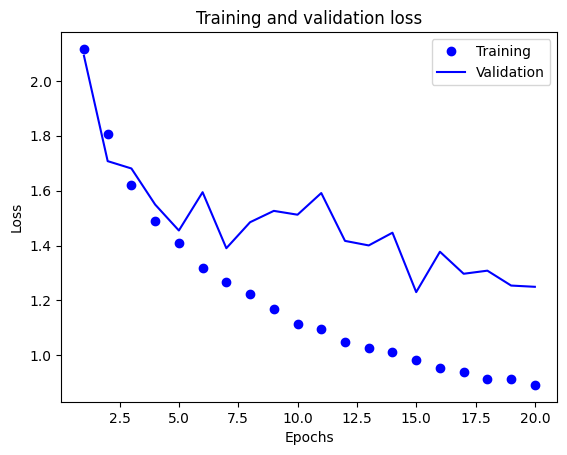

Ideal epoch for validation loss:  15 epochs
Validation loss:  1.2301284074783325


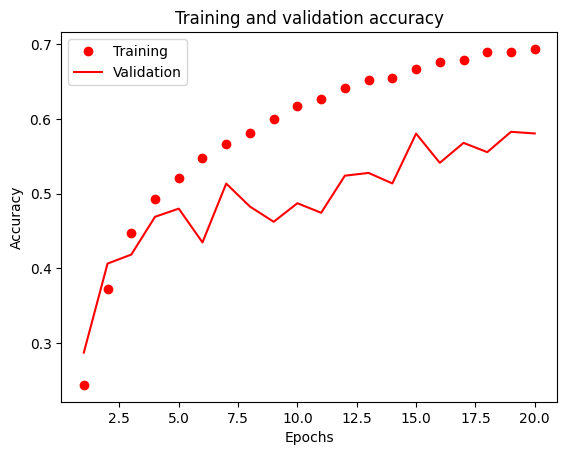

Ideal epoch for validation accuracy:  19 epochs
Validation accuracy:  0.5829164385795593


In [ ]:
plot_val_loss_and_accuracy(cnn_dropout_augmented_history)

43/43 [==============================] - 7s 154ms/step


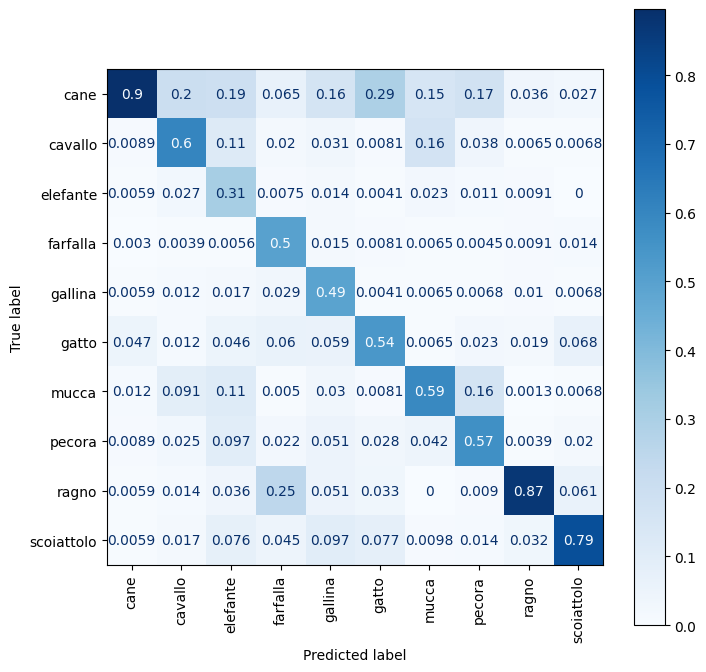

In [ ]:
cnn_dropout_augmented_predictions = cnn_dropout_augmented_model.predict(processed_val_ds)
displayConfusionMatrix(cnn_dropout_augmented_predictions, processed_val_ds)

In [ ]:
displayClassificationReport(cnn_dropout_augmented_predictions, processed_val_ds)

              precision    recall  f1-score   support

        cane       0.90      0.30      0.45       993
     cavallo       0.60      0.60      0.60       521
    elefante       0.31      0.79      0.45       279
    farfalla       0.50      0.91      0.64       438
     gallina       0.49      0.90      0.64       609
       gatto       0.54      0.39      0.45       338
       mucca       0.59      0.43      0.50       422
      pecora       0.57      0.57      0.57       436
       ragno       0.87      0.68      0.77       983
  scoiattolo       0.79      0.31      0.44       378

    accuracy                           0.58      5397
   macro avg       0.62      0.59      0.55      5397
weighted avg       0.67      0.58      0.57      5397



### CNN 3 Evaluation

Data augmentation has had a detrimental effect on performance. It seems to have reduced the ability of the network to learn the dataset. This makes sense as the network never sees the same image twice now.

I will try it again but this time I won't augment the validation set, only the training set. I will do this by removing the data augmentation layers from the network itself and instead applying this to the training set only before it is fed into the network.

## CNN 4: Data augmentation of training set only.

Validation loss and accuracy seem quite unstable. Perhaps because the validation dataset is also augmented, since augmentation layers are built into the network.
I will try try only augmenting the training set. I can also see some overfitting in the graph and the overall accuracy is worse than without augmentation.

I will also increase the capcity of the classifier from 256 units to 512 as the previous network didn't learn the training set very well.

In [ ]:
processed_augmented_train_ds = processed_train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
processed_augmented_train_ds = processed_augmented_train_ds.prefetch(buffer_size=AUTOTUNE)



In [ ]:
cnn_augmented_2_model = tf.keras.models.Sequential()
cnn_augmented_2_model.add(tf.keras.layers.Rescaling(1./255))

cnn_augmented_2_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn_augmented_2_model.add(tf.keras.layers.MaxPooling2D(2))

cnn_augmented_2_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_augmented_2_model.add(tf.keras.layers.MaxPooling2D(2))


cnn_augmented_2_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_augmented_2_model.add(tf.keras.layers.MaxPooling2D(2))


cnn_augmented_2_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_augmented_2_model.add(tf.keras.layers.MaxPooling2D(2))


cnn_augmented_2_model.add(tf.keras.layers.Flatten())
cnn_augmented_2_model.add(tf.keras.layers.Dense(512, activation='relu'))
cnn_augmented_2_model.add(tf.keras.layers.Dense(10, activation='softmax'))

cnn_augmented_2_model.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [ ]:
#notice the augmented train data. The network itself doesn't include augmentation layers.
cnn_augmented_2_history = cnn_augmented_2_model.fit(
  processed_augmented_train_ds,
  validation_data=processed_val_ds,
  epochs=20
)

Epoch 1/20
169/169 [==============================] - 193s 1s/step - loss: 2.0553 - accuracy: 0.2630 - val_loss: 2.1796 - val_accuracy: 0.2333
Epoch 2/20
169/169 [==============================] - 132s 774ms/step - loss: 1.7336 - accuracy: 0.3985 - val_loss: 2.1075 - val_accuracy: 0.2689
Epoch 3/20
169/169 [==============================] - 132s 776ms/step - loss: 1.5846 - accuracy: 0.4604 - val_loss: 1.8692 - val_accuracy: 0.3691
Epoch 4/20
169/169 [==============================] - 132s 773ms/step - loss: 1.4531 - accuracy: 0.5034 - val_loss: 1.5266 - val_accuracy: 0.4860
Epoch 5/20
169/169 [==============================] - 133s 779ms/step - loss: 1.3566 - accuracy: 0.5368 - val_loss: 1.3776 - val_accuracy: 0.5281
Epoch 6/20
169/169 [==============================] - 134s 782ms/step - loss: 1.2726 - accuracy: 0.5636 - val_loss: 1.3084 - val_accuracy: 0.5340
Epoch 7/20
169/169 [==============================] - 133s 782ms/step - loss: 1.2205 - accuracy: 0.5821 - val_loss: 1.3676 - va

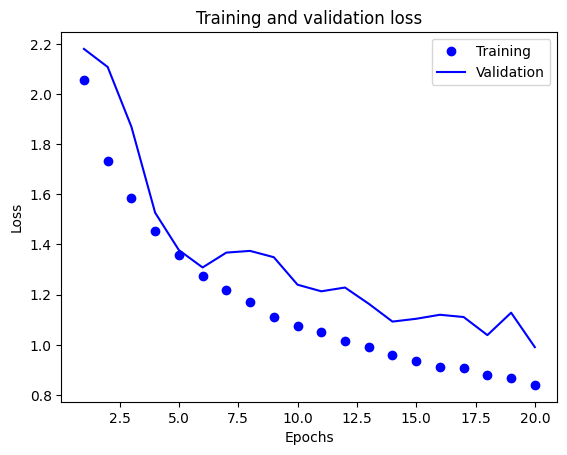

Ideal epoch for validation loss:  20 epochs
Validation loss:  0.990610659122467


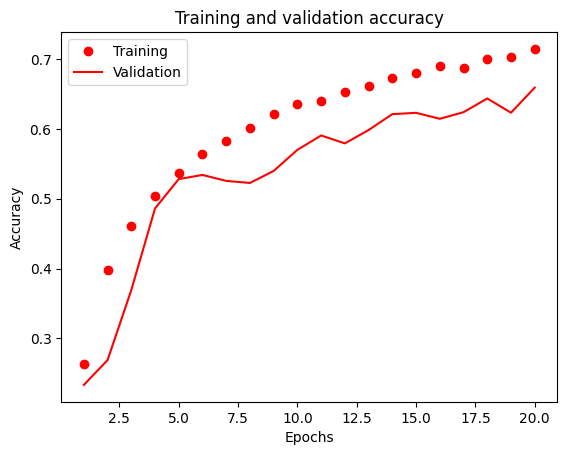

Ideal epoch for validation accuracy:  20 epochs
Validation accuracy:  0.659069836139679


In [ ]:
plot_val_loss_and_accuracy(cnn_augmented_2_history)

43/43 [==============================] - 7s 169ms/step


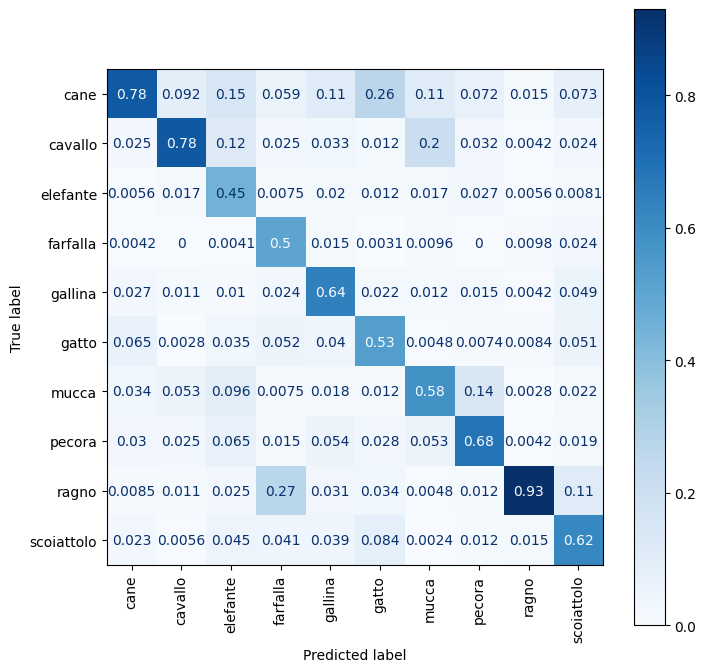

In [ ]:
cnn_augmented_2_predictions = cnn_augmented_2_model.predict(processed_val_ds)
displayConfusionMatrix(cnn_augmented_2_predictions, processed_val_ds)

In [ ]:
displayClassificationReport(cnn_augmented_2_predictions, processed_val_ds)

              precision    recall  f1-score   support

        cane       0.78      0.56      0.65       993
     cavallo       0.78      0.54      0.64       521
    elefante       0.45      0.78      0.57       279
    farfalla       0.50      0.91      0.65       438
     gallina       0.64      0.86      0.73       609
       gatto       0.53      0.50      0.52       338
       mucca       0.58      0.57      0.58       422
      pecora       0.68      0.64      0.66       436
       ragno       0.93      0.68      0.78       983
  scoiattolo       0.62      0.61      0.61       378

    accuracy                           0.66      5397
   macro avg       0.65      0.66      0.64      5397
weighted avg       0.70      0.66      0.66      5397



### CNN 4 Evaluation

Much better than before but still short of the performance without using data augmentation.

I could increase network capacity or train longer to see how it goes.

## Inception Neural Network

We move on to explore an Inception Neural Network architecture. It is a kind of CNN network which performs multiple convolutions concurrently of different kernel sizes.

In [ ]:
# This function creates an inception module and attaches it to the start layer passed in.
# It also takes the number of filters to use on each convolutional layer.
def inceptionModule(start_layer, filters_size = 32):

  branch_a = tf.keras.layers.Conv2D(filters_size, 1, activation='relu', strides=2)(start_layer)

  branch_b = tf.keras.layers.Conv2D(filters_size, 1, activation='relu')(start_layer)
  branch_b = tf.keras.layers.Conv2D(filters_size, 3, activation='relu', strides=2, padding="same")(branch_b)

  branch_c = tf.keras.layers.AveragePooling2D(2, strides=2, padding="same")(start_layer)
  branch_c = tf.keras.layers.Conv2D(filters_size, 3, activation='relu', padding="same")(branch_c)

  branch_d = tf.keras.layers.Conv2D(filters_size, 1, activation='relu')(start_layer)
  branch_d = tf.keras.layers.Conv2D(filters_size, 3, activation='relu', padding="same" )(branch_d)
  branch_d = tf.keras.layers.Conv2D(filters_size, 3, activation='relu', strides=2, padding="same")(branch_d)

  output = tf.keras.layers.concatenate([branch_a, branch_b, branch_c, branch_d], axis=-1)
  return output

## Inception Network 1

We start with an Inception Network using 2 Inception blocks to see how it compares to the CNN networks we did previously.

In [ ]:
#Build Inception Network
inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 32)
inceptBlock2 = inceptionModule(inceptBlock1, 32)

avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(inceptBlock2)
flat = tf.keras.layers.Flatten()(avgPooling)
dense = tf.keras.layers.Dense(128, activation="relu")(flat)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dense)

inceptionModel = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

### Visualise Network Summary and Plot Architecture

We visualise the network's architecture to validate that the inception blocks have been created successfuly and that the shape of the network matches our expectations which it does.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 150, 150, 32  128         ['rescaling_5[0][0]']            
                                )                                                                 
                                                                                              

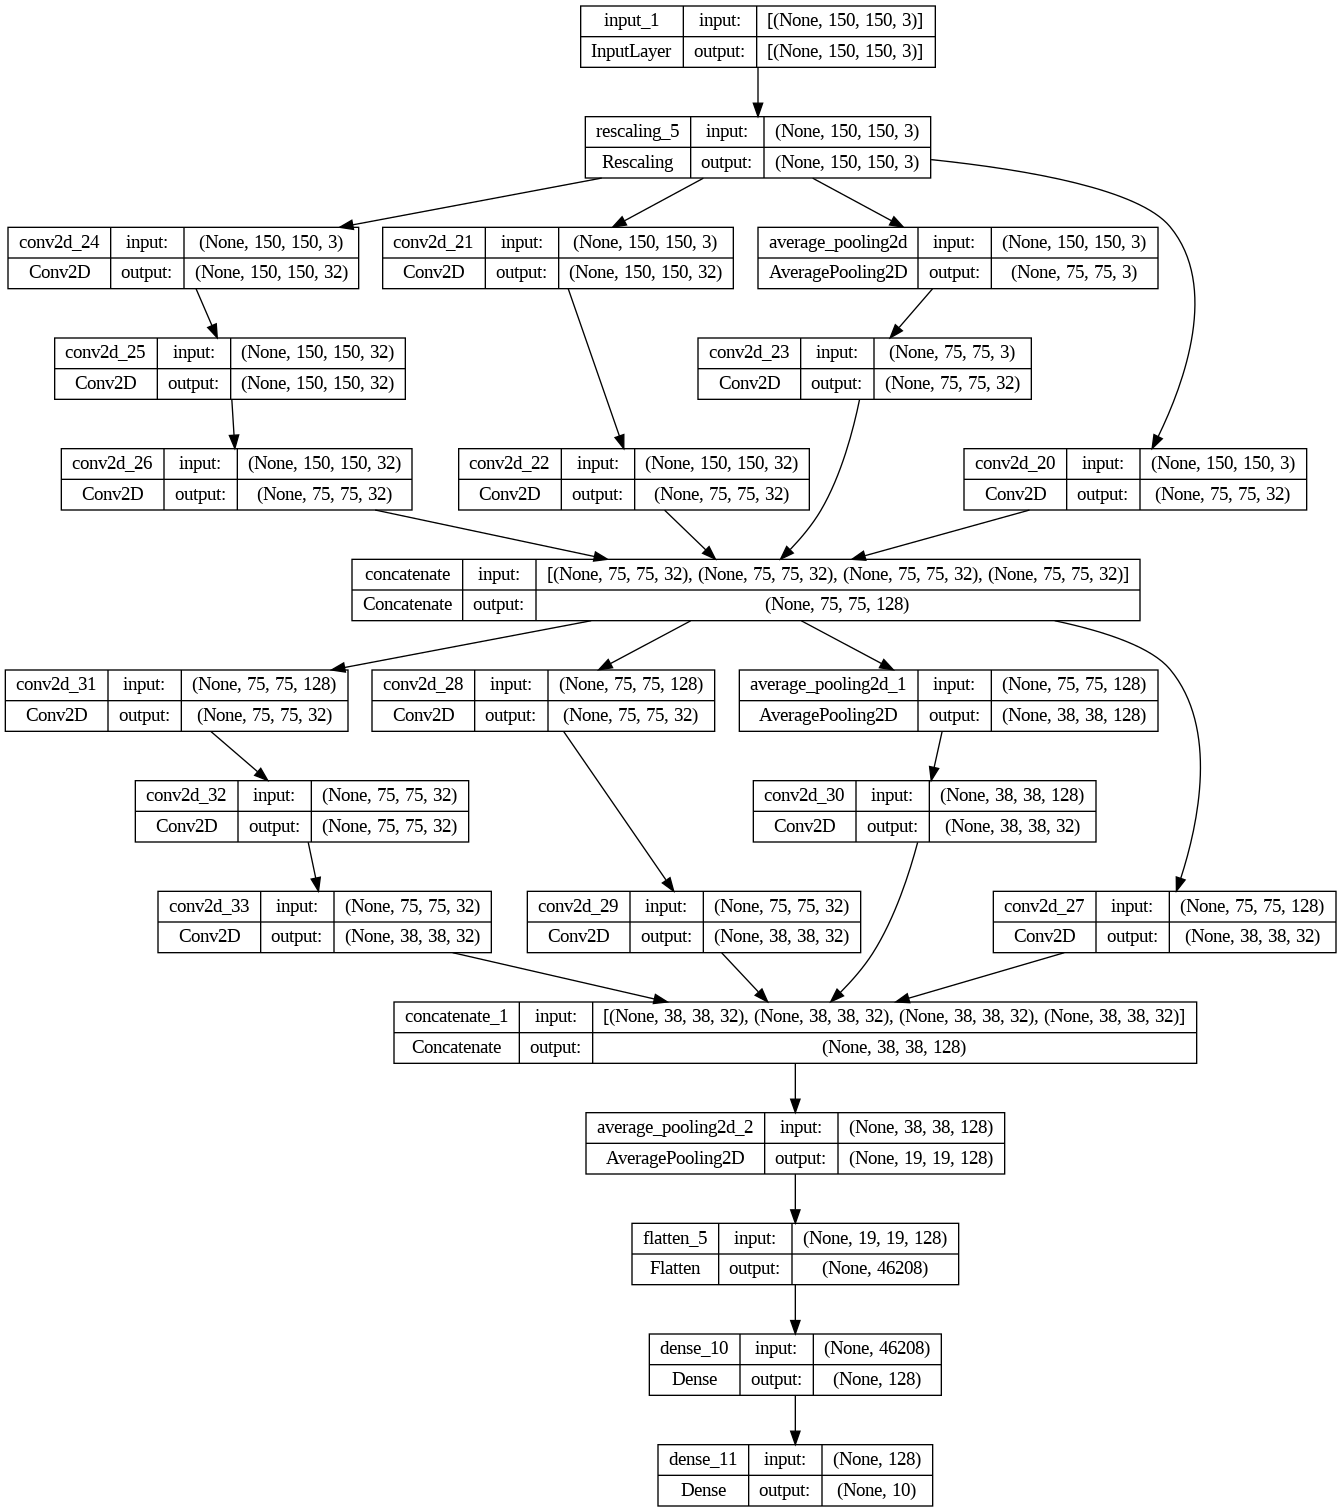

In [ ]:
inceptionModel.summary()

tf.keras.utils.plot_model(inceptionModel, show_shapes=True)

In [ ]:
inceptionModel.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

incept_history = inceptionModel.fit(
    processed_train_ds,
    validation_data=processed_val_ds,
    epochs=15
)

Epoch 1/15
169/169 [==============================] - 502s 3s/step - loss: 1.9757 - accuracy: 0.3039 - val_loss: 1.6625 - val_accuracy: 0.4243
Epoch 2/15
169/169 [==============================] - 504s 3s/step - loss: 1.4687 - accuracy: 0.4973 - val_loss: 1.3853 - val_accuracy: 0.5307
Epoch 3/15
169/169 [==============================] - 494s 3s/step - loss: 1.2038 - accuracy: 0.5962 - val_loss: 1.2813 - val_accuracy: 0.5648
Epoch 4/15
169/169 [==============================] - 466s 3s/step - loss: 0.9684 - accuracy: 0.6763 - val_loss: 1.2542 - val_accuracy: 0.5881
Epoch 5/15
169/169 [==============================] - 490s 3s/step - loss: 0.7673 - accuracy: 0.7448 - val_loss: 1.4515 - val_accuracy: 0.5649
Epoch 6/15
169/169 [==============================] - 507s 3s/step - loss: 0.6143 - accuracy: 0.7955 - val_loss: 1.6548 - val_accuracy: 0.5692
Epoch 7/15
169/169 [==============================] - 463s 3s/step - loss: 0.4837 - accuracy: 0.8391 - val_loss: 1.9497 - val_accuracy: 0.5662

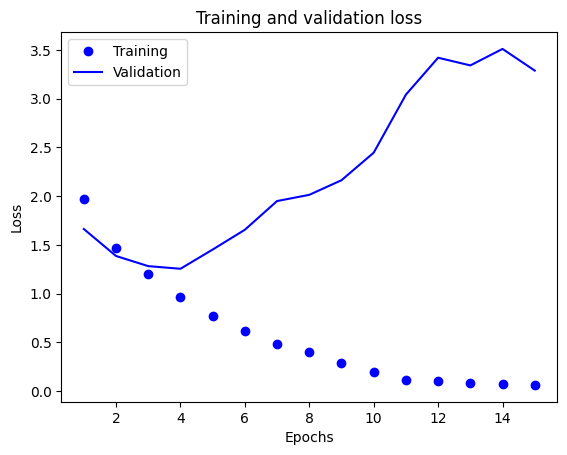

Ideal epoch for validation loss:  4 epochs
Validation loss:  1.2541788816452026


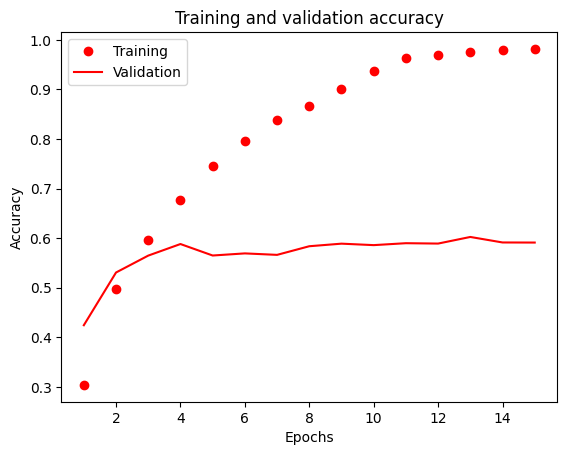

Ideal epoch for validation accuracy:  13 epochs
Validation accuracy:  0.6023716926574707


In [ ]:
plot_val_loss_and_accuracy(incept_history)

43/43 [==============================] - 19s 432ms/step


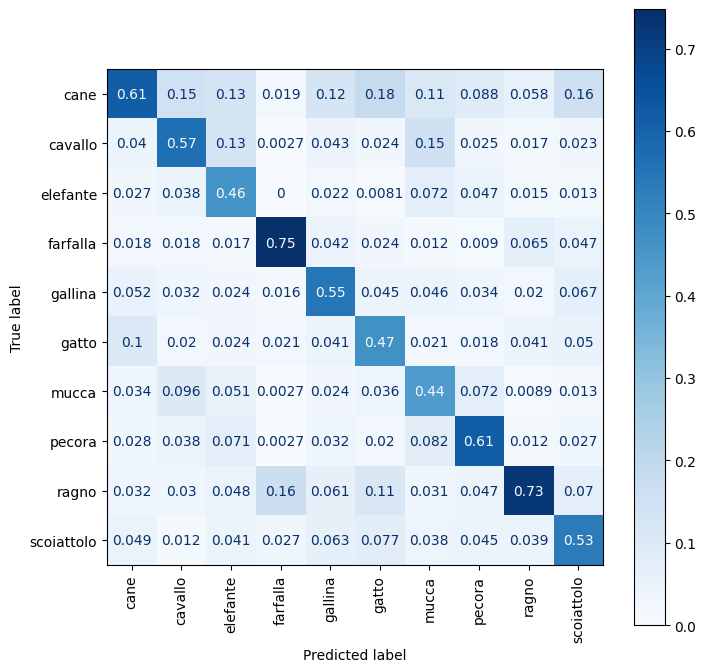

In [ ]:
incept_predictions = inceptionModel.predict(processed_val_ds)
displayConfusionMatrix(incept_predictions, processed_val_ds)

In [ ]:
displayClassificationReport(incept_predictions, processed_val_ds)

              precision    recall  f1-score   support

        cane       0.61      0.52      0.57       993
     cavallo       0.57      0.54      0.55       521
    elefante       0.46      0.48      0.47       279
    farfalla       0.75      0.64      0.69       438
     gallina       0.55      0.73      0.63       609
       gatto       0.47      0.34      0.40       338
       mucca       0.44      0.61      0.51       422
      pecora       0.61      0.62      0.62       436
       ragno       0.73      0.74      0.73       983
  scoiattolo       0.53      0.42      0.47       378

    accuracy                           0.59      5397
   macro avg       0.57      0.56      0.56      5397
weighted avg       0.60      0.59      0.59      5397



### Inception 1 Evaluation

The network archives fair results on the vaildation set. But what stands out is that is has learned the training set almost perfectly and the overfitting is huge. This tells me that this kind of network has massive capacity and the dataset we are working with isn't big enough to ripe the benfits.

I will try things to decrease overfitting and increase performance in the next iterations of the network.

## Inception Network 2: Dropout and More Average Pooling

Next I will add a big dropout layer after the inception modules and before the classifier to decrease the capacity of the network. I will also increase the ratio of the average pooling layer from 2,2 to 3,3 which also reduces capacity.

In [ ]:
#try to reduce overfitting in the inception network

inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 32)
inceptBlock2 = inceptionModule(inceptBlock1, 32)

#ave pooling - factors by which to downscale - 3 times smaller
avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(3, 3))(inceptBlock2)
flat = tf.keras.layers.Flatten()(avgPooling)
#dropout - fractionof the input units to drop
dropout = tf.keras.layers.Dropout(0.4)(flat)
dense = tf.keras.layers.Dense(128, activation="relu")(dropout)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dense)

inceptionModelRegularised = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)


In [ ]:
inceptionModelRegularised.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

incept_regularised_history = inceptionModelRegularised.fit(
    processed_train_ds,
    validation_data=processed_val_ds,
    epochs=15
)

Epoch 1/15
169/169 [==============================] - 529s 3s/step - loss: 1.9023 - accuracy: 0.3281 - val_loss: 1.6422 - val_accuracy: 0.4310
Epoch 2/15
169/169 [==============================] - 505s 3s/step - loss: 1.5277 - accuracy: 0.4754 - val_loss: 1.4474 - val_accuracy: 0.5001
Epoch 3/15
169/169 [==============================] - 505s 3s/step - loss: 1.3299 - accuracy: 0.5505 - val_loss: 1.2955 - val_accuracy: 0.5601
Epoch 4/15
169/169 [==============================] - 507s 3s/step - loss: 1.1717 - accuracy: 0.6050 - val_loss: 1.1816 - val_accuracy: 0.5996
Epoch 5/15
169/169 [==============================] - 506s 3s/step - loss: 1.0596 - accuracy: 0.6417 - val_loss: 1.1282 - val_accuracy: 0.6213
Epoch 6/15
169/169 [==============================] - 511s 3s/step - loss: 0.9786 - accuracy: 0.6727 - val_loss: 1.1013 - val_accuracy: 0.6316
Epoch 7/15
169/169 [==============================] - 509s 3s/step - loss: 0.8946 - accuracy: 0.6971 - val_loss: 1.1016 - val_accuracy: 0.6383

Ideas to improve overfitting:

1.   Data Augmentation
2.   Reduce number of filters in the inception convolutions



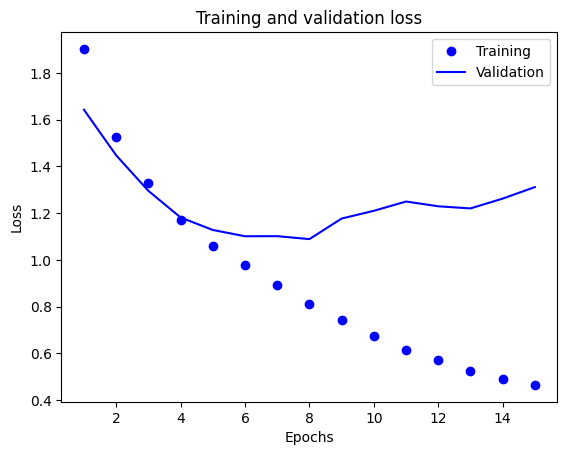

Ideal epoch for validation loss:  8 epochs
Validation loss:  1.0890756845474243


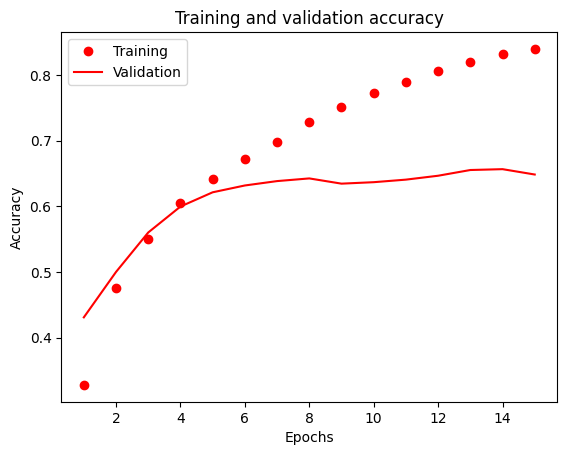

Ideal epoch for validation accuracy:  14 epochs
Validation accuracy:  0.656475841999054


In [ ]:
plot_val_loss_and_accuracy(incept_regularised_history)

### Inception 2 Evaluation

This has helped with overfitting and the performance of the network. Val accuracy has gone up to 0.65. However overfitting is still present and this is still not as good as the best CNN network.

I will try reducing the capacity even further.

## Inception Network 3: Further reduce overfitting

Reduce convolutional filters from 32 to 20 per layer.
Add extra dropout of 0.1 before final softmax layer

In [ ]:
inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 20)
inceptBlock2 = inceptionModule(inceptBlock1, 20)

#ave pooling - factors by which to downscale - 3 times smaller
avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(3, 3))(inceptBlock2)
flat = tf.keras.layers.Flatten()(avgPooling)
#dropout - fractionof the input units to drop
dropout = tf.keras.layers.Dropout(0.4)(flat)
dense = tf.keras.layers.Dense(128, activation="relu")(dropout)
dropout2 = tf.keras.layers.Dropout(0.1)(dense)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dropout2)

inceptionModelRegularised2 = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

In [ ]:
inceptionModelRegularised2.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

incept_regularised_2_history = inceptionModelRegularised2.fit(
    processed_train_ds,
    validation_data=processed_val_ds,
    epochs=20
)

Epoch 1/20
169/169 [==============================] - 331s 2s/step - loss: 1.9159 - accuracy: 0.3194 - val_loss: 1.6517 - val_accuracy: 0.4365
Epoch 2/20
169/169 [==============================] - 357s 2s/step - loss: 1.5565 - accuracy: 0.4663 - val_loss: 1.4185 - val_accuracy: 0.5296
Epoch 3/20
169/169 [==============================] - 357s 2s/step - loss: 1.3594 - accuracy: 0.5393 - val_loss: 1.2956 - val_accuracy: 0.5694
Epoch 4/20
169/169 [==============================] - 355s 2s/step - loss: 1.2206 - accuracy: 0.5849 - val_loss: 1.2675 - val_accuracy: 0.5683
Epoch 5/20
169/169 [==============================] - 354s 2s/step - loss: 1.1359 - accuracy: 0.6190 - val_loss: 1.1938 - val_accuracy: 0.5998
Epoch 6/20
169/169 [==============================] - 356s 2s/step - loss: 1.0465 - accuracy: 0.6469 - val_loss: 1.1383 - val_accuracy: 0.6196
Epoch 7/20
169/169 [==============================] - 359s 2s/step - loss: 0.9639 - accuracy: 0.6747 - val_loss: 1.0852 - val_accuracy: 0.6352

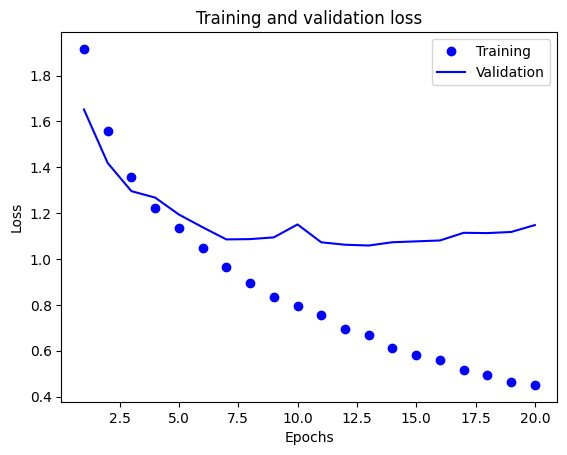

Ideal epoch for validation loss:  13 epochs
Validation loss:  1.0585238933563232


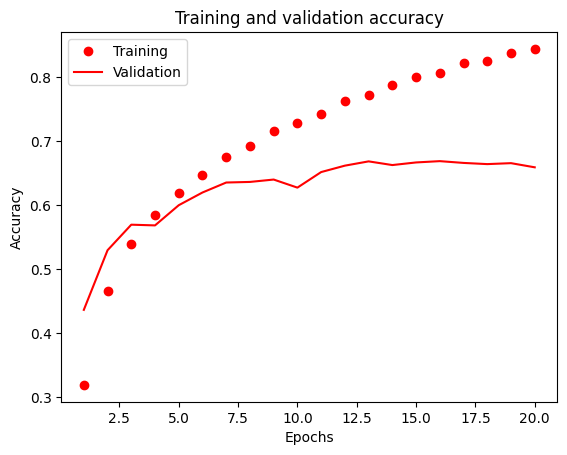

Ideal epoch for validation accuracy:  16 epochs
Validation accuracy:  0.6685195565223694
43/43 [==============================] - 12s 270ms/step
              precision    recall  f1-score   support

        cane       0.57      0.74      0.64       993
     cavallo       0.73      0.52      0.61       521
    elefante       0.51      0.61      0.55       279
    farfalla       0.80      0.74      0.77       438
     gallina       0.74      0.69      0.72       609
       gatto       0.53      0.38      0.44       338
       mucca       0.64      0.51      0.57       422
      pecora       0.60      0.69      0.64       436
       ragno       0.80      0.78      0.79       983
  scoiattolo       0.55      0.58      0.57       378

    accuracy                           0.66      5397
   macro avg       0.65      0.62      0.63      5397
weighted avg       0.67      0.66      0.66      5397



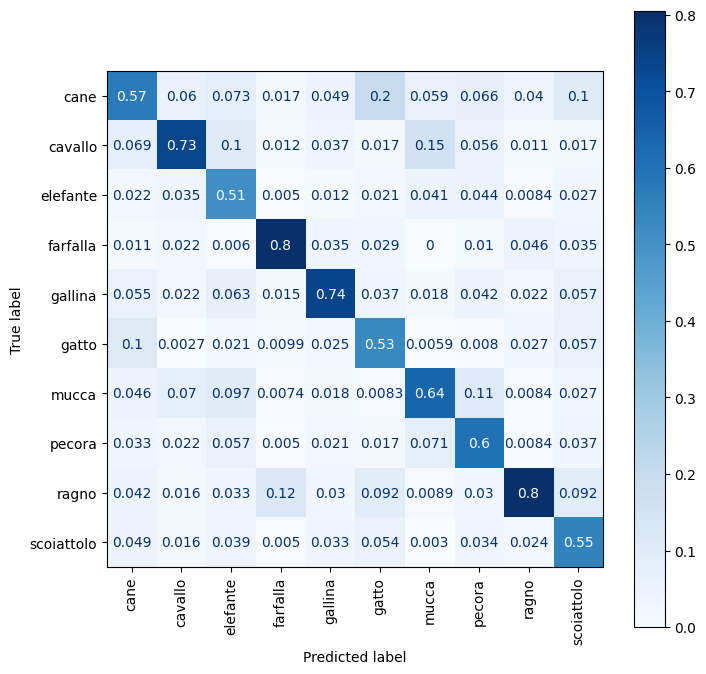

In [ ]:
plot_val_loss_and_accuracy(incept_regularised_2_history)

incept_regularised_2_predictions = inceptionModelRegularised2.predict(processed_val_ds)
displayConfusionMatrix(incept_regularised_2_predictions, processed_val_ds)
displayClassificationReport(incept_regularised_2_predictions, processed_val_ds)

### Inception 3 Evaluation

Performance remained the same, network is a bit too powerful still and overfitting is happening.

## Inception Network 4: Use data augmentation

It is clear that the network is learning the trainig set too closely despite the regularisation techniques. I will use data augmenation to ensure the network does not see the same image twice, thus greatly reducing the change of it learning the training set completely.

In [ ]:
inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 10)
inceptBlock2 = inceptionModule(inceptBlock1, 10)

#ave pooling - factors by which to downscale - 3 times smaller
avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(inceptBlock2)
flat = tf.keras.layers.Flatten()(avgPooling)
#dropout - fractionof the input units to drop
dropout = tf.keras.layers.Dropout(0.3)(flat)
dense = tf.keras.layers.Dense(128, activation="relu")(dropout)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dense)

inceptionModelRegularised3 = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

inceptionModelRegularised3.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

incept_regularised_3_history = inceptionModelRegularised3.fit(
    processed_augmented_train_ds,
    validation_data=processed_val_ds,
    epochs=15
)

Epoch 1/15
169/169 [==============================] - 135s 771ms/step - loss: 2.1459 - accuracy: 0.2326 - val_loss: 1.9011 - val_accuracy: 0.3213
Epoch 2/15
169/169 [==============================] - 130s 763ms/step - loss: 1.9202 - accuracy: 0.3198 - val_loss: 1.7645 - val_accuracy: 0.3858
Epoch 3/15
169/169 [==============================] - 130s 763ms/step - loss: 1.8289 - accuracy: 0.3622 - val_loss: 1.6778 - val_accuracy: 0.4176
Epoch 4/15
169/169 [==============================] - 129s 756ms/step - loss: 1.7567 - accuracy: 0.3893 - val_loss: 1.5637 - val_accuracy: 0.4616
Epoch 5/15
169/169 [==============================] - 130s 760ms/step - loss: 1.7047 - accuracy: 0.4123 - val_loss: 1.5120 - val_accuracy: 0.4751
Epoch 6/15
169/169 [==============================] - 130s 760ms/step - loss: 1.6425 - accuracy: 0.4354 - val_loss: 1.5185 - val_accuracy: 0.4691
Epoch 7/15
169/169 [==============================] - 130s 764ms/step - loss: 1.6053 - accuracy: 0.4494 - val_loss: 1.4561 -

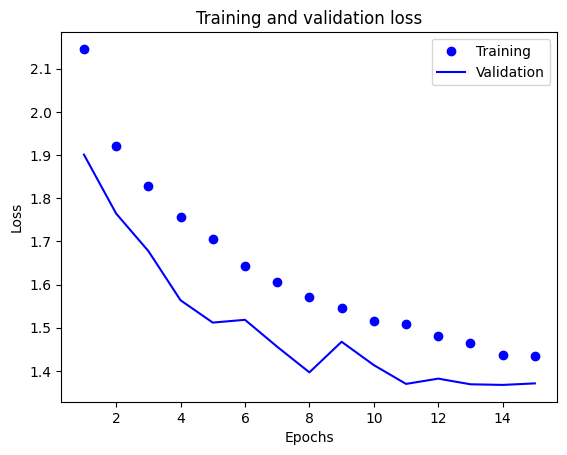

Ideal epoch for validation loss:  14 epochs
Validation loss:  1.367645263671875


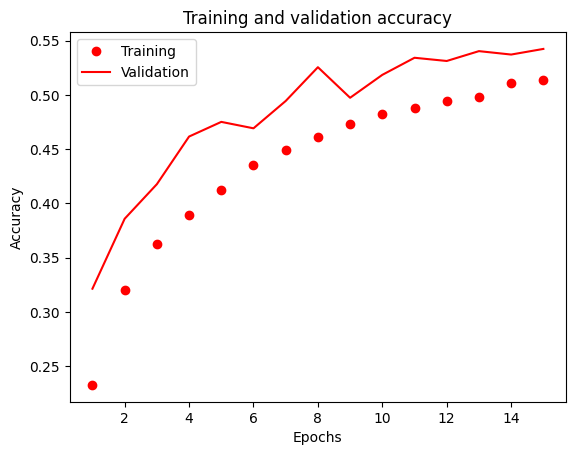

Ideal epoch for validation accuracy:  15 epochs
Validation accuracy:  0.5423383116722107


In [ ]:
plot_val_loss_and_accuracy(incept_regularised_3_history)

### Inception 4 Evaluation

Now overfitting is no longer happening but the network is not learning enough.
I will try increasing the capacity of the network by doing:

- Using 12 filters for convolutional layers
- Increasing the amount of inception blocks to 3
- Increased the classifier to be a dense 512 unit layer
- Remove dropout layer. Data augmentation seems to regularise enough

## Inception Network 5

In [ ]:
inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 12)
inceptBlock2 = inceptionModule(inceptBlock1, 12)
inceptBlock3 = inceptionModule(inceptBlock2, 12)

#ave pooling - factors by which to downscale - 3 times smaller
avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(inceptBlock3)
flat = tf.keras.layers.Flatten()(avgPooling)
dense = tf.keras.layers.Dense(512, activation="relu")(flat)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dense)

inceptionModelRegularised4 = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

inceptionModelRegularised4.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

incept_regularised_4_history = inceptionModelRegularised4.fit(
    processed_augmented_train_ds,
    validation_data=processed_val_ds,
    epochs=20
)

Epoch 1/20
169/169 [==============================] - 291s 2s/step - loss: 2.0296 - accuracy: 0.2703 - val_loss: 1.7852 - val_accuracy: 0.3776
Epoch 2/20
169/169 [==============================] - 208s 1s/step - loss: 1.7928 - accuracy: 0.3718 - val_loss: 1.5788 - val_accuracy: 0.4706
Epoch 3/20
169/169 [==============================] - 209s 1s/step - loss: 1.6884 - accuracy: 0.4166 - val_loss: 1.5199 - val_accuracy: 0.4805
Epoch 4/20
169/169 [==============================] - 195s 1s/step - loss: 1.5955 - accuracy: 0.4538 - val_loss: 1.4156 - val_accuracy: 0.5284
Epoch 5/20
169/169 [==============================] - 191s 1s/step - loss: 1.5325 - accuracy: 0.4774 - val_loss: 1.3721 - val_accuracy: 0.5309
Epoch 6/20
169/169 [==============================] - 210s 1s/step - loss: 1.4677 - accuracy: 0.4996 - val_loss: 1.3599 - val_accuracy: 0.5294
Epoch 7/20
169/169 [==============================] - 211s 1s/step - loss: 1.4366 - accuracy: 0.5059 - val_loss: 1.3074 - val_accuracy: 0.5422

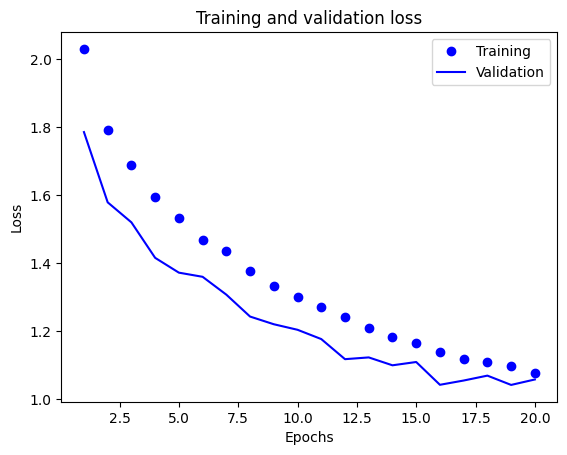

Ideal epoch for validation loss:  19 epochs
Validation loss:  1.0421594381332397


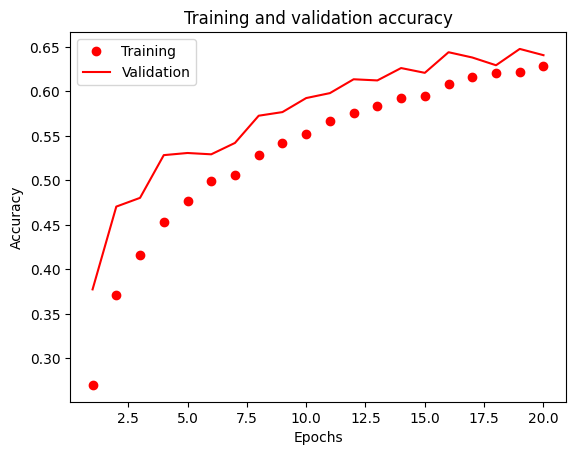

Ideal epoch for validation accuracy:  19 epochs
Validation accuracy:  0.6477673053741455
43/43 [==============================] - 7s 161ms/step
              precision    recall  f1-score   support

        cane       0.68      0.55      0.61       993
     cavallo       0.58      0.64      0.60       521
    elefante       0.70      0.37      0.48       279
    farfalla       0.65      0.82      0.72       438
     gallina       0.62      0.85      0.72       609
       gatto       0.65      0.23      0.34       338
       mucca       0.51      0.57      0.54       422
      pecora       0.53      0.65      0.58       436
       ragno       0.78      0.79      0.79       983
  scoiattolo       0.61      0.59      0.60       378

    accuracy                           0.64      5397
   macro avg       0.63      0.60      0.60      5397
weighted avg       0.65      0.64      0.63      5397



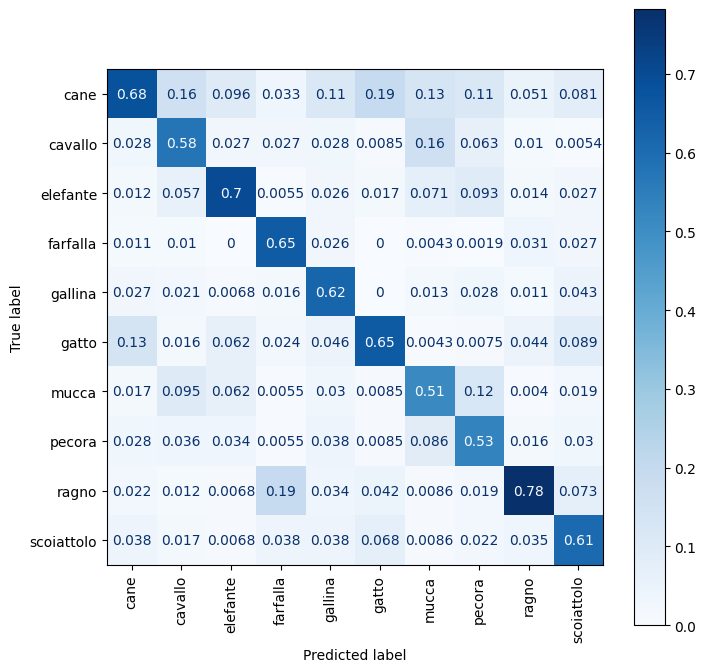

In [ ]:
plot_val_loss_and_accuracy(incept_regularised_4_history)
incept_regularised_4_predictions = inceptionModelRegularised4.predict(processed_val_ds)
displayConfusionMatrix(incept_regularised_4_predictions, processed_val_ds)
displayClassificationReport(incept_regularised_4_predictions, processed_val_ds)

### Inception 5 Evaluation

The model seems quite good now, although it is not yet reaching 70% accuracy as with CNN.

I do not see any overfitting yet so I will try to increase capacity as follows:

- Add extra inception block (4)
- Increase Adam's optimiser's learning rate to 0.005
- Make the classifier be 2 layers instead of one.

## Inception Network 6

In [ ]:
inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 12)
inceptBlock2 = inceptionModule(inceptBlock1, 12)
inceptBlock3 = inceptionModule(inceptBlock2, 12)
inceptBlock4 = inceptionModule(inceptBlock3, 12)

#ave pooling - factors by which to downscale - 2 times smaller
avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(inceptBlock4)
flat = tf.keras.layers.Flatten()(avgPooling)
#classifier dense layers
dense = tf.keras.layers.Dense(256, activation="relu")(flat)
dense2 = tf.keras.layers.Dense(256, activation="relu")(dense)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dense2)

inceptionModelRegularised5 = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

inceptionModelRegularised5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss="categorical_crossentropy",
    metrics=["accuracy"])

incept_regularised_5_history = inceptionModelRegularised5.fit(
    processed_augmented_train_ds,
    validation_data=processed_val_ds,
    epochs=20
)

Epoch 1/20
169/169 [==============================] - 197s 1s/step - loss: 2.1459 - accuracy: 0.2116 - val_loss: 1.9901 - val_accuracy: 0.2653
Epoch 2/20
169/169 [==============================] - 192s 1s/step - loss: 1.9366 - accuracy: 0.3041 - val_loss: 1.7933 - val_accuracy: 0.3761
Epoch 3/20
169/169 [==============================] - 193s 1s/step - loss: 1.7998 - accuracy: 0.3703 - val_loss: 1.6868 - val_accuracy: 0.4078
Epoch 4/20
169/169 [==============================] - 193s 1s/step - loss: 1.7362 - accuracy: 0.3914 - val_loss: 1.6412 - val_accuracy: 0.4280
Epoch 5/20
169/169 [==============================] - 192s 1s/step - loss: 1.6923 - accuracy: 0.4095 - val_loss: 1.5572 - val_accuracy: 0.4565
Epoch 6/20
169/169 [==============================] - 192s 1s/step - loss: 1.6457 - accuracy: 0.4301 - val_loss: 1.4839 - val_accuracy: 0.4797
Epoch 7/20
169/169 [==============================] - 192s 1s/step - loss: 1.5999 - accuracy: 0.4490 - val_loss: 1.4673 - val_accuracy: 0.4864

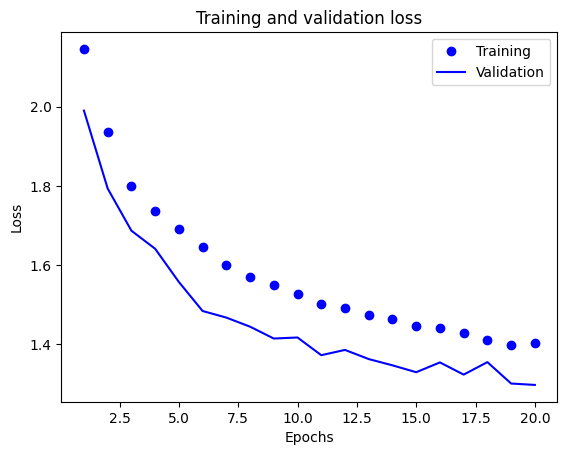

Ideal epoch for validation loss:  20 epochs
Validation loss:  1.2972484827041626


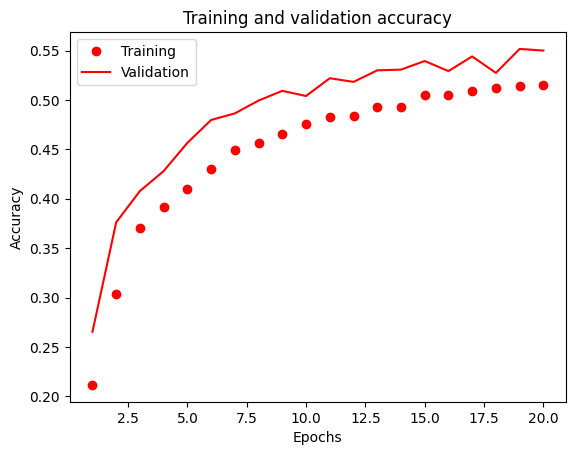

Ideal epoch for validation accuracy:  19 epochs
Validation accuracy:  0.5516027212142944
43/43 [==============================] - 7s 156ms/step


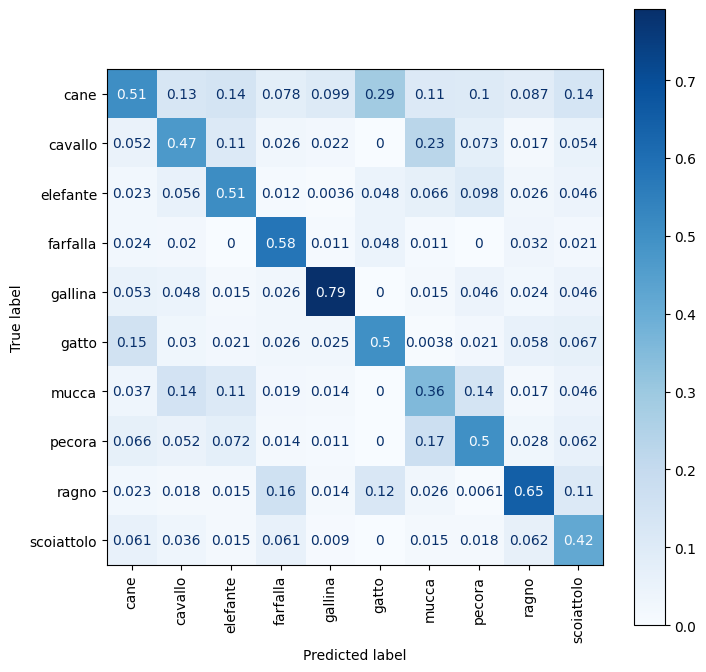

In [ ]:
plot_val_loss_and_accuracy(incept_regularised_5_history)
incept_regularised_5_predictions = inceptionModelRegularised5.predict(processed_val_ds)
displayConfusionMatrix(incept_regularised_5_predictions, processed_val_ds)

### Inception 6 Evaluation

Increasing the learning rate was a mistake and greatly reduced the performance of the network. I will revent that in the next model.

The network before last was no longer overfitting but it was not learning the trainig set well enough. This is understandable because data augmentation is being used.

My hypothesis now is that I can increase the size of the network considerably since overfitting is unlikely. I will test this in the next network.

## Inception Network 7

I will increase capacity as follows:

- Increase to 4 inception modules with 30 filters each.
- Increase the classifier greatly by having 4 layers of 1024 units each.
- I will add slight dropout layers in the classifier to control overfitting since I have increase it so much in size.





In [ ]:
inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 30)
inceptBlock2 = inceptionModule(inceptBlock1, 30)
inceptBlock3 = inceptionModule(inceptBlock2, 30)
inceptBlock4 = inceptionModule(inceptBlock3, 30)

#ave pooling - factors by which to downscale - 2 times smaller
avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(inceptBlock4)
flat = tf.keras.layers.Flatten()(avgPooling)
#classifier dense layers
dense = tf.keras.layers.Dense(1024, activation="relu")(flat)
dp1 = tf.keras.layers.Dropout(0.2)(dense)
dense2 = tf.keras.layers.Dense(1024, activation="relu")(dp1)
dp2 = tf.keras.layers.Dropout(0.2)(dense2)
dense3 = tf.keras.layers.Dense(1024, activation="relu")(dp2)
dp3 = tf.keras.layers.Dropout(0.2)(dense3)
dense4 = tf.keras.layers.Dense(1024, activation="relu")(dp3)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dense4)

inceptionModelRegularised8 = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

inceptionModelRegularised8.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

incept_regularised_8_history = inceptionModelRegularised8.fit(
    processed_augmented_train_ds,
    validation_data=processed_val_ds,
    epochs=30
)

Epoch 1/30
169/169 [==============================] - 474s 3s/step - loss: 2.1592 - accuracy: 0.1982 - val_loss: 2.0444 - val_accuracy: 0.2375
Epoch 2/30
169/169 [==============================] - 467s 3s/step - loss: 1.9845 - accuracy: 0.2755 - val_loss: 1.7747 - val_accuracy: 0.3845
Epoch 3/30
169/169 [==============================] - 467s 3s/step - loss: 1.8135 - accuracy: 0.3652 - val_loss: 1.6196 - val_accuracy: 0.4436
Epoch 4/30
169/169 [==============================] - 467s 3s/step - loss: 1.6994 - accuracy: 0.4162 - val_loss: 1.4944 - val_accuracy: 0.4853
Epoch 5/30
169/169 [==============================] - 467s 3s/step - loss: 1.6006 - accuracy: 0.4483 - val_loss: 1.4021 - val_accuracy: 0.5207
Epoch 6/30
169/169 [==============================] - 467s 3s/step - loss: 1.5207 - accuracy: 0.4813 - val_loss: 1.2856 - val_accuracy: 0.5555
Epoch 7/30
169/169 [==============================] - 467s 3s/step - loss: 1.4529 - accuracy: 0.5002 - val_loss: 1.2744 - val_accuracy: 0.5594

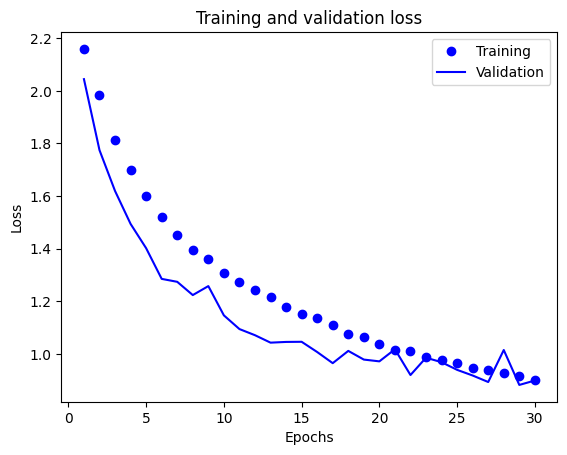

Ideal epoch for validation loss:  29 epochs
Validation loss:  0.8827149868011475


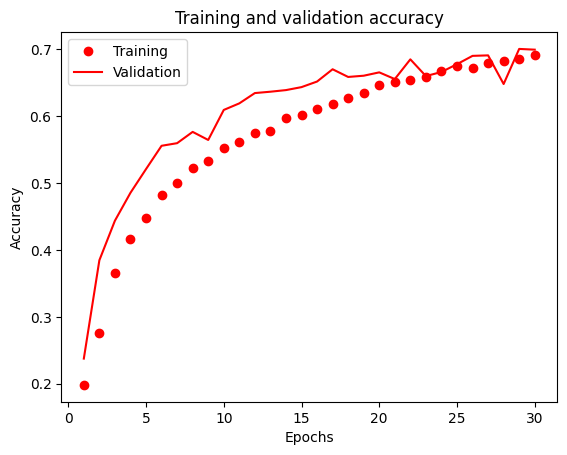

Ideal epoch for validation accuracy:  29 epochs
Validation accuracy:  0.7002038359642029
43/43 [==============================] - 18s 402ms/step
              precision    recall  f1-score   support

        cane       0.79      0.58      0.67       993
     cavallo       0.68      0.61      0.64       521
    elefante       0.54      0.71      0.61       279
    farfalla       0.72      0.85      0.78       438
     gallina       0.81      0.84      0.83       609
       gatto       0.65      0.46      0.54       338
       mucca       0.51      0.59      0.55       422
      pecora       0.54      0.75      0.63       436
       ragno       0.84      0.82      0.83       983
  scoiattolo       0.64      0.70      0.67       378

    accuracy                           0.70      5397
   macro avg       0.67      0.69      0.67      5397
weighted avg       0.71      0.70      0.70      5397



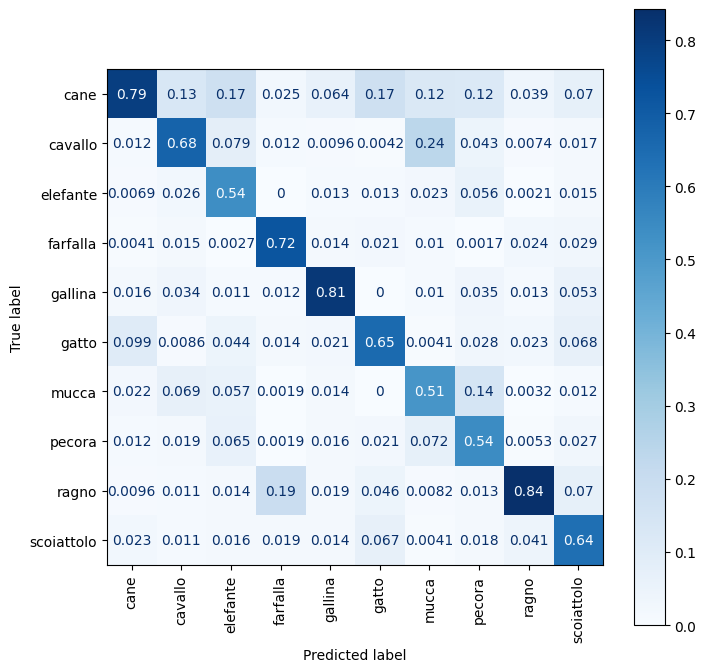

In [ ]:
plot_val_loss_and_accuracy(incept_regularised_8_history)
incept_regularised_8_predictions = inceptionModelRegularised8.predict(processed_val_ds)
displayConfusionMatrix(incept_regularised_8_predictions, processed_val_ds)
displayClassificationReport(incept_regularised_8_predictions, processed_val_ds)

### Inception 7 Evaluation

This gives me very good results, F1 score of 70% which is comparable to what I got in the CNN network. However, looking at the graphs, the network was still learning when the training stopped. This leads me to believe that I might get better performance by training for a bit longer. I will test this next.

## Inception network 8

Keep everything the same but train for longer (40 epochs)

In [ ]:
inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 30)
inceptBlock2 = inceptionModule(inceptBlock1, 30)
inceptBlock3 = inceptionModule(inceptBlock2, 30)
inceptBlock4 = inceptionModule(inceptBlock3, 30)

#ave pooling - factors by which to downscale - 2 times smaller
avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(inceptBlock4)
flat = tf.keras.layers.Flatten()(avgPooling)
#classifier dense layers
dense = tf.keras.layers.Dense(1024, activation="relu")(flat)
dp1 = tf.keras.layers.Dropout(0.2)(dense)
dense2 = tf.keras.layers.Dense(1024, activation="relu")(dp1)
dp2 = tf.keras.layers.Dropout(0.2)(dense2)
dense3 = tf.keras.layers.Dense(1024, activation="relu")(dp2)
dp3 = tf.keras.layers.Dropout(0.2)(dense3)
dense4 = tf.keras.layers.Dense(1024, activation="relu")(dp3)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dense4)

inceptionModelRegularised9 = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

inceptionModelRegularised9.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

incept_regularised_9_history = inceptionModelRegularised9.fit(
    processed_augmented_train_ds,
    validation_data=processed_val_ds,
    epochs=40
)

Epoch 1/40
169/169 [==============================] - 637s 4s/step - loss: 2.1695 - accuracy: 0.1984 - val_loss: 2.0045 - val_accuracy: 0.2542
Epoch 2/40
169/169 [==============================] - 581s 3s/step - loss: 2.0119 - accuracy: 0.2674 - val_loss: 1.8505 - val_accuracy: 0.3426
Epoch 3/40
169/169 [==============================] - 592s 3s/step - loss: 1.8431 - accuracy: 0.3542 - val_loss: 1.6233 - val_accuracy: 0.4308
Epoch 4/40
169/169 [==============================] - 601s 4s/step - loss: 1.7104 - accuracy: 0.4111 - val_loss: 1.5264 - val_accuracy: 0.4727
Epoch 5/40
169/169 [==============================] - 599s 4s/step - loss: 1.6463 - accuracy: 0.4338 - val_loss: 1.4775 - val_accuracy: 0.4943
Epoch 6/40
169/169 [==============================] - 581s 3s/step - loss: 1.5817 - accuracy: 0.4565 - val_loss: 1.4115 - val_accuracy: 0.5149
Epoch 7/40
169/169 [==============================] - 578s 3s/step - loss: 1.5325 - accuracy: 0.4746 - val_loss: 1.3669 - val_accuracy: 0.5310

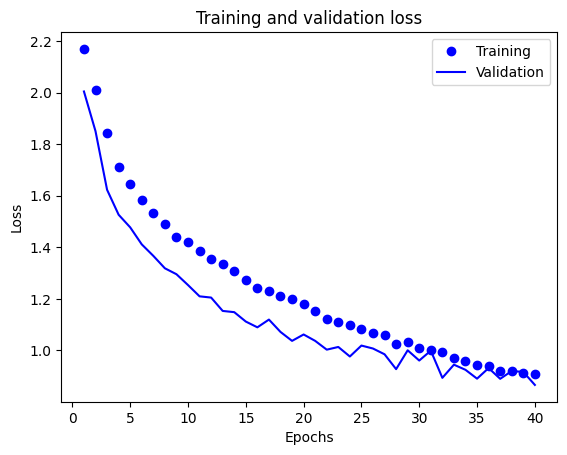

Ideal epoch for validation loss:  40 epochs
Validation loss:  0.8663870096206665


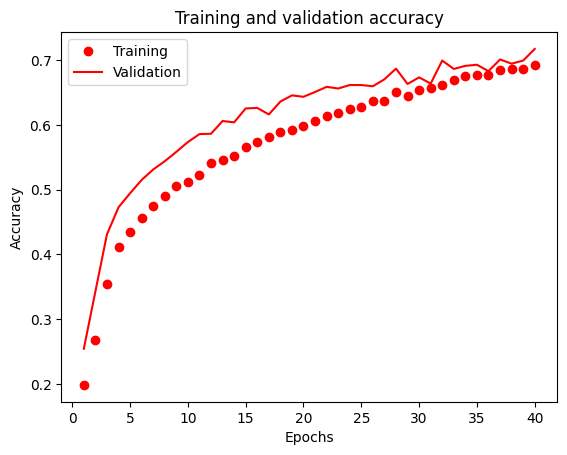

Ideal epoch for validation accuracy:  40 epochs
Validation accuracy:  0.7172503471374512
43/43 [==============================] - 21s 485ms/step
              precision    recall  f1-score   support

        cane       0.73      0.68      0.70       993
     cavallo       0.76      0.64      0.69       521
    elefante       0.64      0.65      0.64       279
    farfalla       0.72      0.87      0.79       438
     gallina       0.89      0.82      0.85       609
       gatto       0.57      0.52      0.54       338
       mucca       0.58      0.60      0.59       422
      pecora       0.57      0.76      0.65       436
       ragno       0.86      0.81      0.83       983
  scoiattolo       0.60      0.66      0.63       378

    accuracy                           0.72      5397
   macro avg       0.69      0.70      0.69      5397
weighted avg       0.73      0.72      0.72      5397



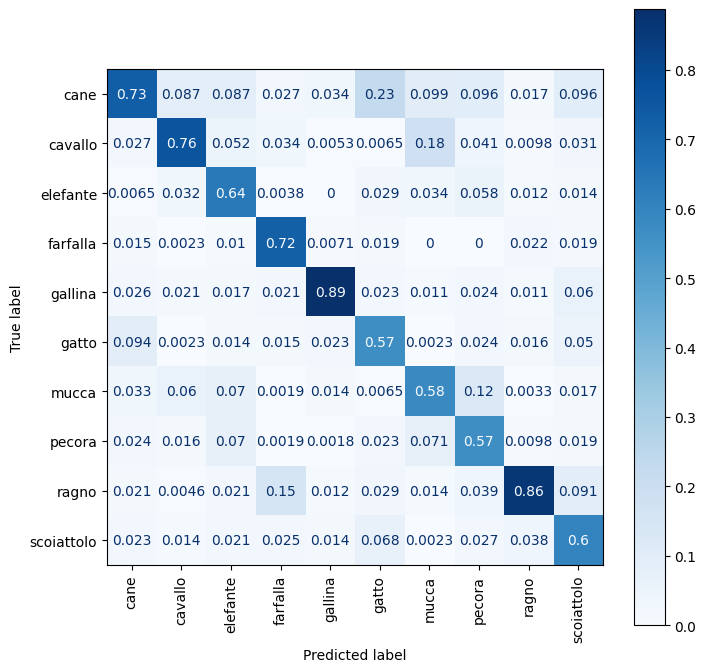

In [ ]:
plot_val_loss_and_accuracy(incept_regularised_9_history)
incept_regularised_9_predictions = inceptionModelRegularised9.predict(processed_val_ds)
displayConfusionMatrix(incept_regularised_9_predictions, processed_val_ds)
displayClassificationReport(incept_regularised_9_predictions, processed_val_ds)

### Inception 8 Evaluation

As predicted the network kept learning more by training longer.
F1 score is now 72% which is better than the CNN network.

I am happy with this network and it achieves better results than the CNN network.

Looking at the graphs, it looks as though the learning is just stopping at the end of training. I will run one more experiment in order to confirm the network has been squeezed as much as possible. I will run the training for much longer (70 epochs) and see what happens. I would expect it to start overfitting at this point.

## Inception Network 9: Run same network for much longer (70 epochs)

In [ ]:
inputLayer = tf.keras.Input(shape=(150, 150, 3))
rescalingLayer = tf.keras.layers.Rescaling(1./255)(inputLayer)

inceptBlock1 = inceptionModule(rescalingLayer, 30)
inceptBlock2 = inceptionModule(inceptBlock1, 30)
inceptBlock3 = inceptionModule(inceptBlock2, 30)
inceptBlock4 = inceptionModule(inceptBlock3, 30)

#ave pooling - factors by which to downscale - 2 times smaller
avgPooling = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(inceptBlock4)
flat = tf.keras.layers.Flatten()(avgPooling)
#classifier dense layers
dense = tf.keras.layers.Dense(1024, activation="relu")(flat)
dp1 = tf.keras.layers.Dropout(0.2)(dense)
dense2 = tf.keras.layers.Dense(1024, activation="relu")(dp1)
dp2 = tf.keras.layers.Dropout(0.2)(dense2)
dense3 = tf.keras.layers.Dense(1024, activation="relu")(dp2)
dp3 = tf.keras.layers.Dropout(0.2)(dense3)
dense4 = tf.keras.layers.Dense(1024, activation="relu")(dp3)
outputLayer = tf.keras.layers.Dense(num_classes, activation="softmax")(dense4)

inceptionModelRegularised10 = tf.keras.Model(inputs=inputLayer, outputs=outputLayer)

inceptionModelRegularised10.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

incept_regularised_10_history = inceptionModelRegularised10.fit(
    processed_augmented_train_ds,
    validation_data=processed_val_ds,
    epochs=70
)

Epoch 1/70
169/169 [==============================] - 555s 3s/step - loss: 2.1364 - accuracy: 0.2144 - val_loss: 1.9456 - val_accuracy: 0.2966
Epoch 2/70
169/169 [==============================] - 510s 3s/step - loss: 1.9373 - accuracy: 0.2986 - val_loss: 1.7257 - val_accuracy: 0.3884
Epoch 3/70
169/169 [==============================] - 513s 3s/step - loss: 1.7666 - accuracy: 0.3844 - val_loss: 1.5519 - val_accuracy: 0.4582
Epoch 4/70
169/169 [==============================] - 509s 3s/step - loss: 1.6505 - accuracy: 0.4359 - val_loss: 1.4298 - val_accuracy: 0.5101
Epoch 5/70
169/169 [==============================] - 511s 3s/step - loss: 1.5591 - accuracy: 0.4650 - val_loss: 1.3411 - val_accuracy: 0.5429
Epoch 6/70
169/169 [==============================] - 509s 3s/step - loss: 1.4859 - accuracy: 0.4896 - val_loss: 1.2911 - val_accuracy: 0.5638
Epoch 7/70
169/169 [==============================] - 506s 3s/step - loss: 1.4402 - accuracy: 0.5082 - val_loss: 1.2572 - val_accuracy: 0.5611

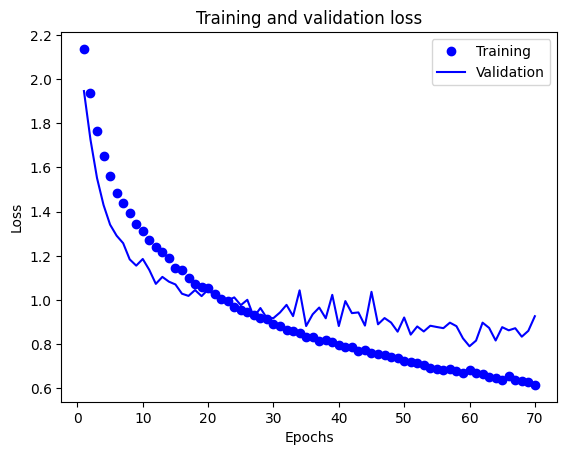

Ideal epoch for validation loss:  60 epochs
Validation loss:  0.7907410264015198


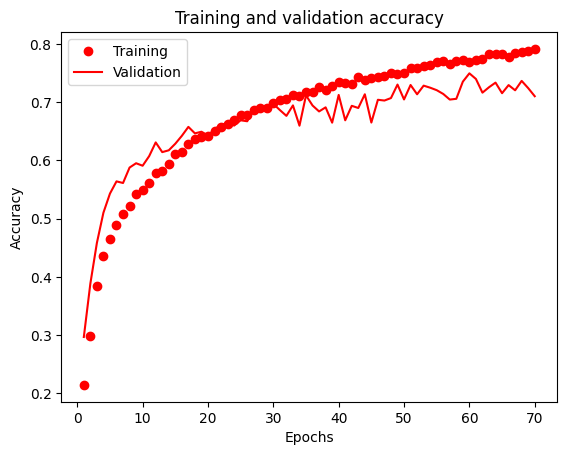

Ideal epoch for validation accuracy:  60 epochs
Validation accuracy:  0.7493051886558533
43/43 [==============================] - 19s 445ms/step
              precision    recall  f1-score   support

        cane       0.86      0.59      0.70       993
     cavallo       0.58      0.68      0.63       521
    elefante       0.48      0.83      0.61       279
    farfalla       0.68      0.89      0.77       438
     gallina       0.86      0.83      0.84       609
       gatto       0.66      0.59      0.63       338
       mucca       0.54      0.64      0.58       422
      pecora       0.60      0.67      0.63       436
       ragno       0.91      0.76      0.83       983
  scoiattolo       0.74      0.68      0.71       378

    accuracy                           0.71      5397
   macro avg       0.69      0.72      0.69      5397
weighted avg       0.74      0.71      0.71      5397



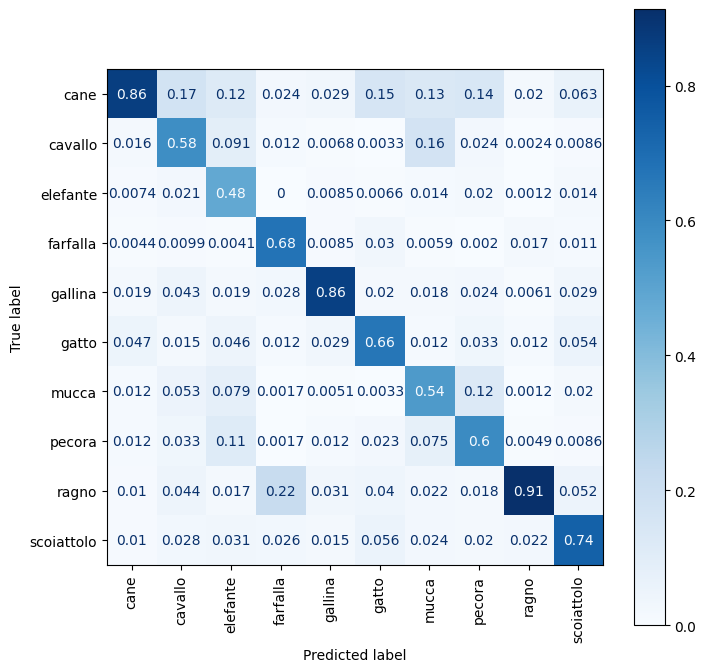

In [ ]:
plot_val_loss_and_accuracy(incept_regularised_10_history)
incept_regularised_10_predictions = inceptionModelRegularised10.predict(processed_val_ds)
displayConfusionMatrix(incept_regularised_10_predictions, processed_val_ds)
displayClassificationReport(incept_regularised_10_predictions, processed_val_ds)

### Inception 10 Evaluation

As predicted the network F1 score is not better than the previous network, which had the same architecture but was trained for less epochs.

I would stop my experimentations here, as the objectives of my projects have been met. I would write all the details in the final report.